### Imports

In [1]:
import sqlite3 as sql
import pandas as pd
import torch.nn as nn
import torch
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.preprocessing import OneHotEncoder
import tqdm
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import wandb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from utils import *

conn = sql.connect("states.db")
tables_query = "SELECT name FROM sqlite_master WHERE type='table';"
tables_df = pd.read_sql(tables_query, conn)
table_names = tables_df['name'].tolist()[1:]


dataframes = {}
for table_name in table_names:
    dataframes[table_name] = pd.read_sql(f"SELECT * FROM {table_name}", conn)
conn.close()

In [2]:
unemployment_rate = dataframes['unemployment_rate']
state_survival_rates = dataframes['survival_rates']
industry_survival_rates = dataframes['industry_survival_rates']
establishments = dataframes['establishments']
yearly_data = dataframes['yearly_data']

### Data reformatting

Reformat into 1530 samples for state data

In [3]:
state_survival_rates_filtered = state_survival_rates[state_survival_rates["Year Established"] != state_survival_rates["Year"]]
state_survival_rates_filtered.loc[:, "Year"] = state_survival_rates_filtered["Year"].astype('int')
state_survival_rates_filtered.loc[:, "Survival Rates of Previous Year's Survivors"] = state_survival_rates_filtered["Survival Rates of Previous Year's Survivors"].astype('float')
state_survival_rates_filtered.loc[:, 'Surviving Establishments'] = state_survival_rates_filtered['Surviving Establishments'].str.replace(',', '').astype(int)
state_survival_rates_grouped = state_survival_rates_filtered.groupby(["Year", "State"]).apply(lambda x: np.average(x['Survival Rates of Previous Year\'s Survivors'], weights=x['Surviving Establishments']))
#print(state_survival_rates_filtered.head())

Get reformatted industry data

In [4]:
industry_survival_rates_filtered = industry_survival_rates[industry_survival_rates["Year Established"] != industry_survival_rates["Year"]]
industry_survival_rates_filtered.loc[:, "Year"] = industry_survival_rates_filtered["Year"].astype('int')
industry_survival_rates_filtered.loc[:, "Survival Rates of Previous Year's Survivors"] = industry_survival_rates_filtered["Survival Rates of Previous Year's Survivors"].astype('float')
industry_survival_rates_filtered.loc[:, 'Surviving Establishments'] = industry_survival_rates_filtered['Surviving Establishments'].str.replace(',', '').astype(int)
industry_survival_rates_grouped = industry_survival_rates_filtered.groupby(["Year", "Industry"]).apply(lambda x: np.average(x['Survival Rates of Previous Year\'s Survivors'], weights=x['Surviving Establishments']))

print(industry_survival_rates_filtered.head())

  Year Established  Year Surviving Establishments  \
1             1994  1995                     5537   
2             1994  1996                     4826   
3             1994  1997                     4406   
4             1994  1998                     4005   
5             1994  1999                     3729   

  Total Employment of Survivors Survival Rates Since Birth  \
1                        51,066                       82.1   
2                        48,263                       71.6   
3                        47,634                       65.4   
4                        45,444                       59.4   
5                        39,377                       55.3   

  Survival Rates of Previous Year's Survivors Average Employment of Survivors  \
1                                        82.1                             9.2   
2                                        87.2                            10.0   
3                                        91.3                    

In [5]:
total_survival_rate = pd.concat([state_survival_rates_filtered, industry_survival_rates_filtered])
total_survival_rate_grouped = total_survival_rate.groupby(["Year"]).apply(lambda x: np.average(x['Survival Rates of Previous Year\'s Survivors'], weights=x['Surviving Establishments']))
# ^ overall business survival rate by year



In [6]:
conn = sql.connect("states.db")
state_survival_rates_grouped.unstack().to_sql("states_grouped", conn, if_exists="replace", index=False)
industry_survival_rates_grouped.to_sql("industry_grouped", conn, if_exists="replace", index=False)
total_survival_rate_grouped.to_sql("total_grouped", conn, if_exists="replace", index=False)
conn.close()

### Non-Bayesian approach

In [7]:
results = []
for (year, state), state_val in state_survival_rates_grouped.items():
    for (ind_year, industry), ind_val in industry_survival_rates_grouped.items():
        if year == ind_year:
            result = (year, state, industry), (state_val * ind_val) / total_survival_rate_grouped[year]
            results.append(result)

result = pd.Series(dict(results))
unemployment_rate["Year"] = unemployment_rate["Year"].astype('int')

In [8]:
state_df = state_survival_rates_grouped.unstack()
industry_df = industry_survival_rates_grouped.unstack()

In [9]:
pre_df = []
for year in result.index.get_level_values(0).unique():
    for state in state_df.columns:
        unemployment = unemployment_rate[(unemployment_rate["Year"] == year) & (unemployment_rate["State"] == state)]["Unemployment Rate"]
        for industry in industry_df.columns:
            response = result[year, state, industry]
            pre_df.append((year, numerical_state[state], numerical_industry[industry], float(unemployment.iloc[0]), response))
final_dataset = pd.DataFrame(pre_df, columns=["Year", "State", "Industry", "Unemployment Rate", "Response"])
             

### Model

In [ ]:
from models import EconDataset, SurvivalRateModel, SurvivalRateModel_AggressiveReg, SurvivalRateModel_DeepLearning, SurvivalRateModel_Combined, SurvivalRateModel_Embeddings

In [11]:
train_val_data, test_data = train_test_split(final_dataset, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_val_data, test_size=0.125, random_state=42)

# Create DataLoader for training and testing sets
train_dataset = EconDataset(train_data, "State", "Industry", "Unemployment Rate", "Response")
test_dataset = EconDataset(test_data, "State", "Industry", "Unemployment Rate", "Response")
val_dataset = EconDataset(val_data, "State", "Industry", "Unemployment Rate", "Response")


input_size = len(train_dataset[0][0])

### Architecture Variation Testing

#### Load pre-existing if needed:

In [16]:
import pickle

# Load the model from the file
with open('models/model_combined_2000epoch.pkl', 'rb') as f:
    model, loss_data= pickle.load(f)


In [17]:
from models import analyze_model_performance, analyze_survival_rate

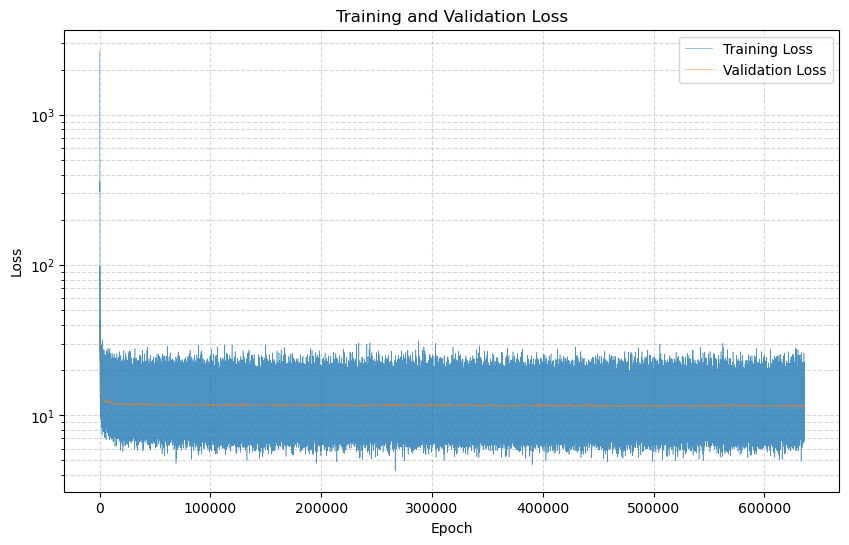

Training MSE: 8740.0498, R^2: -757517.6102
Test MSE: 8745.5381, R^2: -718026.3042


In [19]:
analyze_model_performance(model, loss_data[0], loss_data[1], train_dataloader, test_dataloader, device="cpu")

Test Set Performance:
R² Score: -1.4438
Mean Absolute Error: 5.1566
Root Mean Squared Error: 6.4770


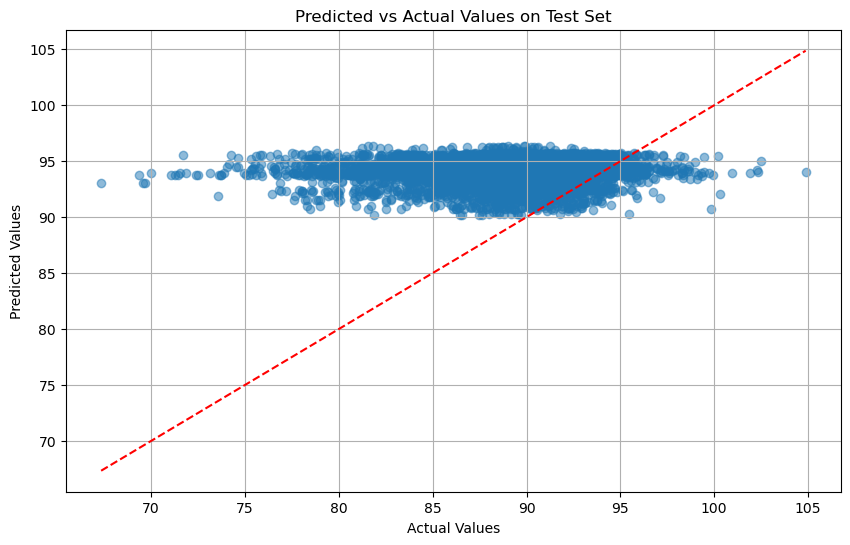

In [24]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Compute R² and loss metrics for the model on the test set

# Get predictions and actual values from the test set
y_pred, y_true = model.evaluate(test_dataloader, device="cpu")
y_true = train_dataset.denormalize_response(y_true)
# Calculate metrics
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"Test Set Performance:")
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")

# Create a scatter plot of predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values on Test Set')
plt.grid(True)
plt.show()

In [19]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

#### v1:

In [ ]:
models = []
model_names = []
train_dataloaders = []
test_dataloaders = []
val_dataloaders = []

# Create DataLoaders with the new EconDataset
train_dataset = EconDataset(train_data, "State", "Industry", "Unemployment Rate", "Response")
test_dataset = EconDataset(test_data, "State", "Industry", "Unemployment Rate", "Response")
val_dataset = EconDataset(val_data, "State", "Industry", "Unemployment Rate", "Response")
input_size = len(train_dataset[0][0])
bs = 128

train_dataloader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=bs, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=bs, shuffle=False)

train_dataloaders.append(train_dataloader)
test_dataloaders.append(test_dataloader)
val_dataloaders.append(val_dataloader)

# 1. Basic SurvivalRateModel (Baseline)
model_basic = SurvivalRateModel(input_size=input_size, hidden_size1=256, hidden_size2=128)
models.append(model_basic)
model_names.append("Basic SurvivalRateModel")

# 2. SurvivalRateModel_Combined (Baseline)
model_combined = SurvivalRateModel_Combined(input_size=input_size, hidden_size1=512, hidden_size2=256, hidden_size3=128, hidden_size4=64)
models.append(model_combined)
model_names.append("SurvivalRateModel_Combined")

# 3. SurvivalRateModel_Combined (No BatchNorm, LayerNorm instead)
class SurvivalRateModel_Combined_LayerNorm(SurvivalRateModel_Combined):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        new_layers = []
        for layer in self.layers:
            if isinstance(layer, nn.BatchNorm1d):
                new_layers.append(nn.LayerNorm(layer.num_features))
            else:
                new_layers.append(layer)
        self.layers = nn.Sequential(*new_layers)

model_combined_layer_norm = SurvivalRateModel_Combined_LayerNorm(input_size=input_size, hidden_size1=512, hidden_size2=256, hidden_size3=128, hidden_size4=64)
models.append(model_combined_layer_norm)
model_names.append("Combined LayerNorm")

# 4. SurvivalRateModel_Combined (No LeakyReLU, ReLU instead)
class SurvivalRateModel_Combined_ReLU(SurvivalRateModel_Combined):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        new_layers = []
        for layer in self.layers:
            if isinstance(layer, nn.LeakyReLU):
                new_layers.append(nn.ReLU())
            else:
                new_layers.append(layer)
        self.layers = nn.Sequential(*new_layers)

model_combined_relu = SurvivalRateModel_Combined_ReLU(input_size=input_size, hidden_size1=512, hidden_size2=256, hidden_size3=128, hidden_size4=64)
models.append(model_combined_relu)
model_names.append("Combined ReLU")

# 5. SurvivalRateModel_Combined (No Dropout)
class SurvivalRateModel_Combined_NoDropout(SurvivalRateModel_Combined):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layers = nn.Sequential(*[layer for layer in self.layers if not isinstance(layer, nn.Dropout)])

model_combined_no_dropout = SurvivalRateModel_Combined_NoDropout(input_size=input_size, hidden_size1=512, hidden_size2=256, hidden_size3=128, hidden_size4=64)
models.append(model_combined_no_dropout)
model_names.append("Combined No Dropout")

# 6. SurvivalRateModel_Combined (Convolutional Layers)
class SurvivalRateModel_Combined_Conv(SurvivalRateModel_Combined):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, output_size=1, l1_lambda=0.0005, l2_lambda=0.01, noise_std=0.05, dropout_rate=0.2):
        super().__init__(input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, output_size, l1_lambda, l2_lambda, noise_std, dropout_rate)
        self.conv_layers = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        self.fc_input_size = 32 * (input_size // 4)
        self.fc_layers = nn.Sequential(
            nn.Linear(self.fc_input_size, hidden_size1),
            nn.ReLU(),
            nn.Linear(hidden_size1, output_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        return 100 * self.fc_layers(x)

model_combined_conv = SurvivalRateModel_Combined_Conv(input_size=input_size, hidden_size1=256, hidden_size2=128, hidden_size3=64, hidden_size4=32)
models.append(model_combined_conv)
model_names.append("Combined Conv Layers")

# 7. SurvivalRateModel_Combined (No Sigmoid)
class SurvivalRateModel_Combined_NoSigmoid(SurvivalRateModel_Combined):
    def forward(self, x):
        return self.layers[:-1](x)

model_combined_no_sigmoid = SurvivalRateModel_Combined_NoSigmoid(input_size=input_size, hidden_size1=512, hidden_size2=256, hidden_size3=128, hidden_size4=64)
models.append(model_combined_no_sigmoid)
model_names.append("Combined No Sigmoid")

# 8. SurvivalRateModel_Combined (Adding Tanh Activation)
class SurvivalRateModel_Combined_Tanh(SurvivalRateModel_Combined):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        new_layers = []
        for layer in self.layers:
            new_layers.append(layer)
            if isinstance(layer, nn.Linear):
                new_layers.append(nn.Tanh())
        self.layers = nn.Sequential(*new_layers[:-1]) #Remove the last Tanh before Sigmoid.

model_combined_tanh = SurvivalRateModel_Combined_Tanh(input_size=input_size, hidden_size1=512, hidden_size2=256, hidden_size3=128, hidden_size4=64)
models.append(model_combined_tanh)
model_names.append("Combined Tanh Activation")

# 9. SurvivalRateModel_Combined (No L1, No L2)
class SurvivalRateModel_Combined_NoReg(SurvivalRateModel_Combined):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.l1_lambda = 0.0
        self.l2_lambda = 0.0

model_combined_no_reg = SurvivalRateModel_Combined_NoReg(input_size=input_size, hidden_size1=512, hidden_size2=256, hidden_size3=128, hidden_size4=64)
models.append(model_combined_no_reg)
model_names.append("Combined No Reg")


# Training and Evaluation Loop
num_epochs = 150
device = "cpu"  # or "cuda" if available

results = []

for i, model in enumerate(models):
    print(f"Training {model_names[i]}...")
    train_loss_cache, val_loss_cache = model.train_loop(
        train_dataloaders[0],  # All models use the same dataloaders
        num_epochs=num_epochs,
        learning_rate=0.001,  # Adjust learning rate if needed
        device=device,
        val_dataloader=val_dataloaders[0],
        suppress=True,
        patience=50,
    )

    y_pred, y_true = model.evaluate(test_dataloaders[0], device=device)

    # Denormalize predictions and actual values
    y_pred_denorm = train_dataset.denormalize_response(y_pred)
    y_true_denorm = train_dataset.denormalize_response(y_true)

    r2 = r2_score(y_true_denorm, y_pred_denorm)
    mae = mean_absolute_error(y_true_denorm, y_pred_denorm)
    rmse = np.sqrt(mean_squared_error(y_true_denorm, y_pred_denorm))

    results.append({
        "model_name": model_names[i],
        "r2": r2,
        "mae": mae,
        "rmse": rmse,
        "y_pred": y_pred_denorm,
        "y_true": y_true_denorm,
    })

# Plotting Results
for result in results:
    print(f"Results for {result['model_name']}:")
    print(f"  R² Score: {result['r2']:.4f}")
    print(f"  Mean Absolute Error: {result['mae']:.4f}")
    print(f"  Root Mean Squared Error: {result['rmse']:.4f}")

    plt.figure(figsize=(10, 6))
    plt.scatter(result['y_true'], result['y_pred'], alpha=0.5)
    plt.plot([min(result['y_true']), max(result['y_true'])], [min(result['y_true']), max(result['y_true'])], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f"Predicted vs Actual Values ({result['model_name']})")
    plt.grid(True)
    plt.show()

Training Basic SurvivalRateModel...


Training Epochs: 100%|██████████| 150/150 [00:56<00:00,  2.66it/s]


Training SurvivalRateModel_Combined...


Training Epochs:  56%|█████▌    | 84/150 [01:33<01:13,  1.11s/it]


Training Combined LayerNorm...


Training Epochs:  71%|███████▏  | 107/150 [01:42<00:41,  1.04it/s]


Training Combined ReLU...


Training Epochs:  57%|█████▋    | 86/150 [01:32<01:08,  1.07s/it]


Training Combined No Dropout...


Training Epochs: 100%|██████████| 150/150 [02:10<00:00,  1.15it/s]


Training Combined Conv Layers...


Training Epochs:  73%|███████▎  | 110/150 [04:55<01:47,  2.69s/it]


Training Combined No Sigmoid...


Training Epochs:  81%|████████▏ | 122/150 [02:19<00:31,  1.14s/it]


Training Combined Tanh Activation...


Training Epochs: 100%|██████████| 150/150 [02:57<00:00,  1.18s/it]


Training Combined No Reg...


Training Epochs: 100%|██████████| 150/150 [02:43<00:00,  1.09s/it]


Training Combined Adaptive Pool...


Training Epochs:   0%|          | 0/150 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (128x1 and 71x256)

#### v2:

Training Basic SurvivalRateModel...


Training Epochs: 100%|██████████| 150/150 [01:40<00:00,  1.49it/s]


Training Basic SurvivalRateModel Aggressive Regularization...


Training Epochs:  47%|████▋     | 70/150 [00:57<01:06,  1.21it/s]


Training Basic SurvivalRateModel Deep Learning...


Training Epochs:  45%|████▍     | 67/150 [00:58<01:12,  1.15it/s]


Training Combined No Reg...


Training Epochs: 100%|██████████| 150/150 [04:04<00:00,  1.63s/it]


Results for Basic SurvivalRateModel:
  R² Score: 0.1115
  Mean Absolute Error: 3.0542
  Root Mean Squared Error: 3.9055


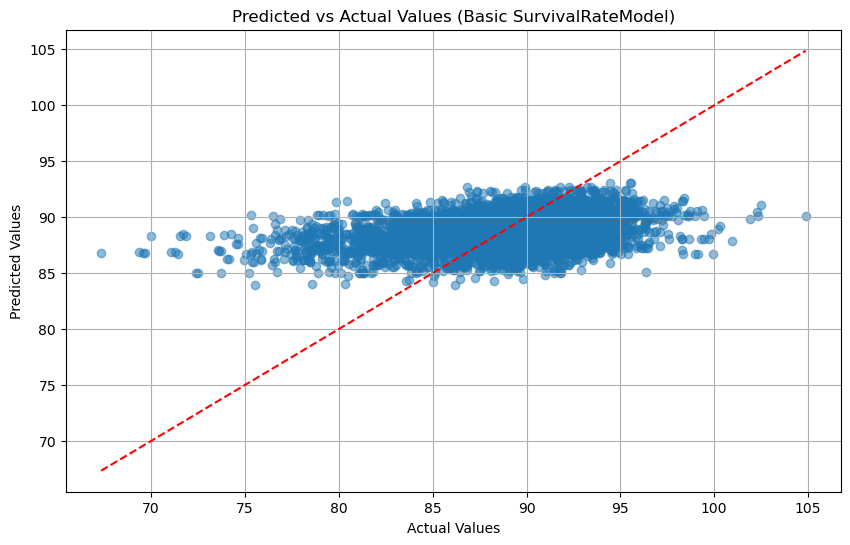

Results for Basic SurvivalRateModel Aggressive Regularization:
  R² Score: -23.1358
  Mean Absolute Error: 17.9544
  Root Mean Squared Error: 20.3550


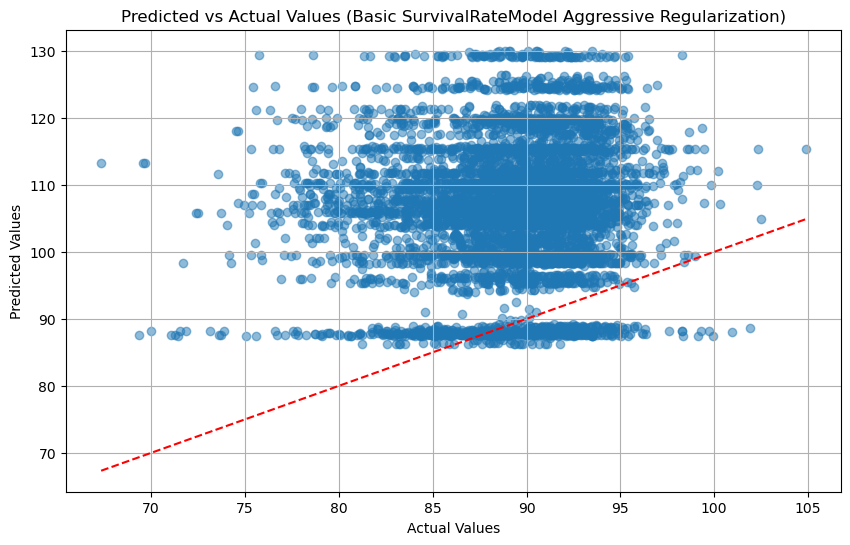

Results for Basic SurvivalRateModel Deep Learning:
  R² Score: -0.0033
  Mean Absolute Error: 3.1818
  Root Mean Squared Error: 4.1501


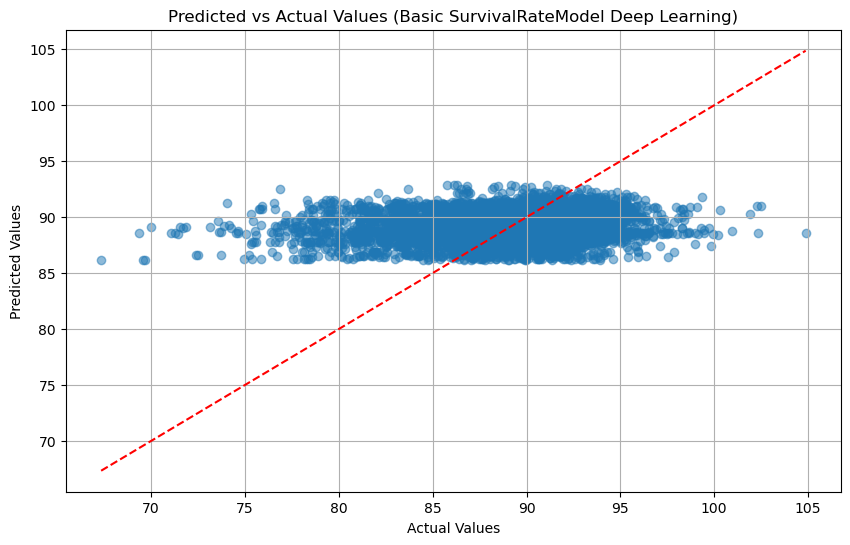

Results for Combined No Reg:
  R² Score: 0.0343
  Mean Absolute Error: 3.0462
  Root Mean Squared Error: 4.0716


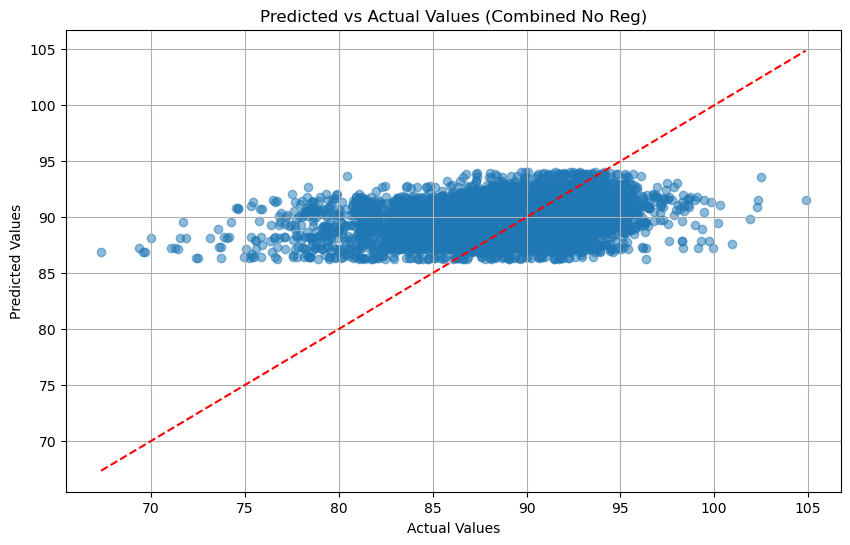

In [20]:
models = []
model_names = []
train_dataloaders = []
test_dataloaders = []
val_dataloaders = []

# Create DataLoaders with the new EconDataset
train_dataset = EconDataset(train_data, "State", "Industry", "Unemployment Rate", "Response")
test_dataset = EconDataset(test_data, "State", "Industry", "Unemployment Rate", "Response")
val_dataset = EconDataset(val_data, "State", "Industry", "Unemployment Rate", "Response")
input_size = len(train_dataset[0][0])
bs = 128

train_dataloader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=bs, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=bs, shuffle=False)

train_dataloaders.append(train_dataloader)
test_dataloaders.append(test_dataloader)
val_dataloaders.append(val_dataloader)

# 1. Basic SurvivalRateModel (Baseline)
model_basic = SurvivalRateModel(input_size=input_size, hidden_size1=256, hidden_size2=128)
models.append(model_basic)
model_names.append("Basic SurvivalRateModel")

model_basic_agrr = SurvivalRateModel_AggressiveReg(input_size=input_size, hidden_size1=256, hidden_size2=128)
models.append(model_basic_agrr)
model_names.append("Basic SurvivalRateModel Aggressive Regularization")

model_basic_deep = SurvivalRateModel_DeepLearning(input_size=input_size, hidden_size1=256, hidden_size2=128, hidden_size3=128, hidden_size4=64)
models.append(model_basic_deep)
model_names.append("Basic SurvivalRateModel Deep Learning")

# 9. SurvivalRateModel_Combined (No L1, No L2)
class SurvivalRateModel_Combined_NoReg(SurvivalRateModel_Combined):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.l1_lambda = 0.0
        self.l2_lambda = 0.0

model_combined_no_reg = SurvivalRateModel_Combined_NoReg(input_size=input_size, hidden_size1=512, hidden_size2=256, hidden_size3=128, hidden_size4=64)
models.append(model_combined_no_reg)
model_names.append("Combined No Reg")

# Training and Evaluation Loop
num_epochs = 150
device = "cpu"  # or "cuda" if available

results = []

for i, model in enumerate(models):
    print(f"Training {model_names[i]}...")
    train_loss_cache, val_loss_cache = model.train_loop(
        train_dataloaders[0],  # All models use the same dataloaders
        num_epochs=num_epochs,
        learning_rate=0.001,  # Adjust learning rate if needed
        device=device,
        val_dataloader=val_dataloaders[0],
        suppress=True,
        patience=50,
    )

    y_pred, y_true = model.evaluate(test_dataloaders[0], device=device)

    # Denormalize predictions and actual values
    y_pred_denorm = train_dataset.denormalize_response(y_pred)
    y_true_denorm = train_dataset.denormalize_response(y_true)

    r2 = r2_score(y_true_denorm, y_pred_denorm)
    mae = mean_absolute_error(y_true_denorm, y_pred_denorm)
    rmse = np.sqrt(mean_squared_error(y_true_denorm, y_pred_denorm))

    results.append({
        "model_name": model_names[i],
        "r2": r2,
        "mae": mae,
        "rmse": rmse,
        "y_pred": y_pred_denorm,
        "y_true": y_true_denorm,
    })

# Plotting Results
for result in results:
    print(f"Results for {result['model_name']}:")
    print(f"  R² Score: {result['r2']:.4f}")
    print(f"  Mean Absolute Error: {result['mae']:.4f}")
    print(f"  Root Mean Squared Error: {result['rmse']:.4f}")

    plt.figure(figsize=(10, 6))
    plt.scatter(result['y_true'], result['y_pred'], alpha=0.5)
    plt.plot([min(result['y_true']), max(result['y_true'])], [min(result['y_true']), max(result['y_true'])], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f"Predicted vs Actual Values ({result['model_name']})")
    plt.grid(True)
    plt.show()

#### v3:

Training RMSprop Optimizer...


Training Epochs:   1%|          | 1/150 [00:00<01:27,  1.71it/s]

Epoch 1/150, Train Loss: 9.0176, Val Loss: 0.0448


Training Epochs:   1%|▏         | 2/150 [00:01<01:27,  1.70it/s]

Epoch 2/150, Train Loss: 0.1184, Val Loss: 0.0375


Training Epochs:   2%|▏         | 3/150 [00:01<01:29,  1.63it/s]

Epoch 3/150, Train Loss: 0.2741, Val Loss: 0.8154


Training Epochs:   3%|▎         | 4/150 [00:02<01:26,  1.69it/s]

Epoch 4/150, Train Loss: 0.2639, Val Loss: 0.3982


Training Epochs:   3%|▎         | 5/150 [00:02<01:23,  1.74it/s]

Epoch 5/150, Train Loss: 0.1787, Val Loss: 0.0920


Training Epochs:   4%|▍         | 6/150 [00:03<01:21,  1.77it/s]

Epoch 6/150, Train Loss: 0.1400, Val Loss: 0.1047


Training Epochs:   5%|▍         | 7/150 [00:04<01:19,  1.79it/s]

Epoch 7/150, Train Loss: 0.1185, Val Loss: 0.0350


Training Epochs:   5%|▌         | 8/150 [00:04<01:18,  1.81it/s]

Epoch 8/150, Train Loss: 0.0784, Val Loss: 0.1177


Training Epochs:   6%|▌         | 9/150 [00:05<01:17,  1.82it/s]

Epoch 9/150, Train Loss: 0.0566, Val Loss: 0.0214


Training Epochs:   7%|▋         | 10/150 [00:05<01:16,  1.82it/s]

Epoch 10/150, Train Loss: 0.0461, Val Loss: 0.0853


Training Epochs:   7%|▋         | 11/150 [00:06<01:16,  1.83it/s]

Epoch 11/150, Train Loss: 0.0337, Val Loss: 0.0297


Training Epochs:   8%|▊         | 12/150 [00:06<01:15,  1.83it/s]

Epoch 12/150, Train Loss: 0.0322, Val Loss: 0.0324


Training Epochs:   9%|▊         | 13/150 [00:07<01:17,  1.77it/s]

Epoch 13/150, Train Loss: 0.0307, Val Loss: 0.0155


Training Epochs:   9%|▉         | 14/150 [00:07<01:16,  1.77it/s]

Epoch 14/150, Train Loss: 0.0293, Val Loss: 0.0561


Training Epochs:  10%|█         | 15/150 [00:08<01:15,  1.80it/s]

Epoch 15/150, Train Loss: 0.0293, Val Loss: 0.0443


Training Epochs:  11%|█         | 16/150 [00:08<01:14,  1.81it/s]

Epoch 16/150, Train Loss: 0.0275, Val Loss: 0.0182


Training Epochs:  11%|█▏        | 17/150 [00:09<01:13,  1.82it/s]

Epoch 17/150, Train Loss: 0.0319, Val Loss: 0.0198


Training Epochs:  12%|█▏        | 18/150 [00:10<01:12,  1.83it/s]

Epoch 18/150, Train Loss: 0.0256, Val Loss: 0.0172


Training Epochs:  13%|█▎        | 19/150 [00:10<01:11,  1.83it/s]

Epoch 19/150, Train Loss: 0.0310, Val Loss: 0.0209


Training Epochs:  13%|█▎        | 20/150 [00:11<01:10,  1.83it/s]

Epoch 20/150, Train Loss: 0.0275, Val Loss: 0.0239


Training Epochs:  14%|█▍        | 21/150 [00:11<01:10,  1.84it/s]

Epoch 21/150, Train Loss: 0.0264, Val Loss: 0.0179


Training Epochs:  15%|█▍        | 22/150 [00:12<01:09,  1.84it/s]

Epoch 22/150, Train Loss: 0.0293, Val Loss: 0.0259


Training Epochs:  15%|█▌        | 23/150 [00:12<01:11,  1.78it/s]

Epoch 23/150, Train Loss: 0.0250, Val Loss: 0.0176


Training Epochs:  16%|█▌        | 24/150 [00:13<01:09,  1.80it/s]

Epoch 24/150, Train Loss: 0.0260, Val Loss: 0.0195


Training Epochs:  17%|█▋        | 25/150 [00:13<01:08,  1.81it/s]

Epoch 25/150, Train Loss: 0.0260, Val Loss: 0.0421


Training Epochs:  17%|█▋        | 26/150 [00:14<01:08,  1.82it/s]

Epoch 26/150, Train Loss: 0.0263, Val Loss: 0.0150


Training Epochs:  18%|█▊        | 27/150 [00:15<01:07,  1.83it/s]

Epoch 27/150, Train Loss: 0.0226, Val Loss: 0.0194


Training Epochs:  19%|█▊        | 28/150 [00:15<01:06,  1.83it/s]

Epoch 28/150, Train Loss: 0.0265, Val Loss: 0.0323


Training Epochs:  19%|█▉        | 29/150 [00:16<01:05,  1.84it/s]

Epoch 29/150, Train Loss: 0.0232, Val Loss: 0.0579


Training Epochs:  20%|██        | 30/150 [00:16<01:05,  1.84it/s]

Epoch 30/150, Train Loss: 0.0241, Val Loss: 0.0193


Training Epochs:  21%|██        | 31/150 [00:17<01:04,  1.84it/s]

Epoch 31/150, Train Loss: 0.0232, Val Loss: 0.0211


Training Epochs:  21%|██▏       | 32/150 [00:17<01:03,  1.85it/s]

Epoch 32/150, Train Loss: 0.0232, Val Loss: 0.0173


Training Epochs:  22%|██▏       | 33/150 [00:18<01:05,  1.80it/s]

Epoch 33/150, Train Loss: 0.0227, Val Loss: 0.0635


Training Epochs:  23%|██▎       | 34/150 [00:18<01:04,  1.80it/s]

Epoch 34/150, Train Loss: 0.0237, Val Loss: 0.0219


Training Epochs:  23%|██▎       | 35/150 [00:19<01:03,  1.81it/s]

Epoch 35/150, Train Loss: 0.0208, Val Loss: 0.0165


Training Epochs:  24%|██▍       | 36/150 [00:19<01:02,  1.82it/s]

Epoch 36/150, Train Loss: 0.0205, Val Loss: 0.0480


Training Epochs:  25%|██▍       | 37/150 [00:20<01:01,  1.83it/s]

Epoch 37/150, Train Loss: 0.0205, Val Loss: 0.0560


Training Epochs:  25%|██▌       | 38/150 [00:21<01:02,  1.78it/s]

Epoch 38/150, Train Loss: 0.0190, Val Loss: 0.0168


Training Epochs:  26%|██▌       | 39/150 [00:21<01:03,  1.75it/s]

Epoch 39/150, Train Loss: 0.0204, Val Loss: 0.0149


Training Epochs:  27%|██▋       | 40/150 [00:22<01:01,  1.78it/s]

Epoch 40/150, Train Loss: 0.0192, Val Loss: 0.0172


Training Epochs:  27%|██▋       | 41/150 [00:22<01:01,  1.78it/s]

Epoch 41/150, Train Loss: 0.0197, Val Loss: 0.0149


Training Epochs:  28%|██▊       | 42/150 [00:23<01:00,  1.80it/s]

Epoch 42/150, Train Loss: 0.0188, Val Loss: 0.0204


Training Epochs:  29%|██▊       | 43/150 [00:23<01:01,  1.75it/s]

Epoch 43/150, Train Loss: 0.0184, Val Loss: 0.0386


Training Epochs:  29%|██▉       | 44/150 [00:24<00:59,  1.78it/s]

Epoch 44/150, Train Loss: 0.0187, Val Loss: 0.0166


Training Epochs:  30%|███       | 45/150 [00:25<00:58,  1.79it/s]

Epoch 45/150, Train Loss: 0.0181, Val Loss: 0.0152


Training Epochs:  31%|███       | 46/150 [00:25<00:57,  1.81it/s]

Epoch 46/150, Train Loss: 0.0184, Val Loss: 0.0156


Training Epochs:  31%|███▏      | 47/150 [00:26<00:56,  1.82it/s]

Epoch 47/150, Train Loss: 0.0170, Val Loss: 0.0162


Training Epochs:  32%|███▏      | 48/150 [00:26<00:55,  1.83it/s]

Epoch 48/150, Train Loss: 0.0168, Val Loss: 0.0173


Training Epochs:  33%|███▎      | 49/150 [00:27<00:55,  1.83it/s]

Epoch 49/150, Train Loss: 0.0179, Val Loss: 0.0270


Training Epochs:  33%|███▎      | 50/150 [00:27<00:54,  1.82it/s]

Epoch 50/150, Train Loss: 0.0172, Val Loss: 0.0247


Training Epochs:  34%|███▍      | 51/150 [00:28<00:54,  1.83it/s]

Epoch 51/150, Train Loss: 0.0156, Val Loss: 0.0161


Training Epochs:  35%|███▍      | 52/150 [00:28<00:53,  1.83it/s]

Epoch 52/150, Train Loss: 0.0166, Val Loss: 0.0224


Training Epochs:  35%|███▌      | 53/150 [00:29<00:54,  1.78it/s]

Epoch 53/150, Train Loss: 0.0162, Val Loss: 0.0148


Training Epochs:  36%|███▌      | 54/150 [00:29<00:53,  1.80it/s]

Epoch 54/150, Train Loss: 0.0158, Val Loss: 0.0254


Training Epochs:  37%|███▋      | 55/150 [00:30<00:52,  1.79it/s]

Epoch 55/150, Train Loss: 0.0151, Val Loss: 0.0205


Training Epochs:  37%|███▋      | 56/150 [00:31<00:52,  1.80it/s]

Epoch 56/150, Train Loss: 0.0150, Val Loss: 0.0245


Training Epochs:  38%|███▊      | 57/150 [00:31<00:51,  1.80it/s]

Epoch 57/150, Train Loss: 0.0155, Val Loss: 0.0185


Training Epochs:  39%|███▊      | 58/150 [00:32<00:50,  1.81it/s]

Epoch 58/150, Train Loss: 0.0152, Val Loss: 0.0195


Training Epochs:  39%|███▉      | 59/150 [00:32<00:50,  1.82it/s]

Epoch 59/150, Train Loss: 0.0142, Val Loss: 0.0168


Training Epochs:  40%|████      | 60/150 [00:33<00:49,  1.82it/s]

Epoch 60/150, Train Loss: 0.0142, Val Loss: 0.0149


Training Epochs:  41%|████      | 61/150 [00:33<00:48,  1.83it/s]

Epoch 61/150, Train Loss: 0.0141, Val Loss: 0.0184


Training Epochs:  41%|████▏     | 62/150 [00:34<00:48,  1.83it/s]

Epoch 62/150, Train Loss: 0.0139, Val Loss: 0.0179


Training Epochs:  42%|████▏     | 63/150 [00:34<00:48,  1.78it/s]

Epoch 63/150, Train Loss: 0.0142, Val Loss: 0.0164


Training Epochs:  43%|████▎     | 64/150 [00:35<00:47,  1.80it/s]

Epoch 64/150, Train Loss: 0.0141, Val Loss: 0.0229


Training Epochs:  43%|████▎     | 65/150 [00:36<00:47,  1.81it/s]

Epoch 65/150, Train Loss: 0.0136, Val Loss: 0.0161


Training Epochs:  44%|████▍     | 66/150 [00:36<00:48,  1.75it/s]

Epoch 66/150, Train Loss: 0.0135, Val Loss: 0.0154


Training Epochs:  45%|████▍     | 67/150 [00:37<00:47,  1.76it/s]

Epoch 67/150, Train Loss: 0.0141, Val Loss: 0.0187


Training Epochs:  45%|████▌     | 68/150 [00:37<00:46,  1.78it/s]

Epoch 68/150, Train Loss: 0.0132, Val Loss: 0.0210


Training Epochs:  46%|████▌     | 69/150 [00:38<00:45,  1.80it/s]

Epoch 69/150, Train Loss: 0.0135, Val Loss: 0.0147


Training Epochs:  47%|████▋     | 70/150 [00:38<00:44,  1.81it/s]

Epoch 70/150, Train Loss: 0.0130, Val Loss: 0.0254


Training Epochs:  47%|████▋     | 71/150 [00:39<00:43,  1.81it/s]

Epoch 71/150, Train Loss: 0.0134, Val Loss: 0.0213


Training Epochs:  48%|████▊     | 72/150 [00:39<00:42,  1.82it/s]

Epoch 72/150, Train Loss: 0.0133, Val Loss: 0.0171


Training Epochs:  49%|████▊     | 73/150 [00:40<00:43,  1.77it/s]

Epoch 73/150, Train Loss: 0.0132, Val Loss: 0.0164


Training Epochs:  49%|████▉     | 74/150 [00:41<00:42,  1.79it/s]

Epoch 74/150, Train Loss: 0.0134, Val Loss: 0.0181


Training Epochs:  50%|█████     | 75/150 [00:41<00:41,  1.81it/s]

Epoch 75/150, Train Loss: 0.0131, Val Loss: 0.0150


Training Epochs:  51%|█████     | 76/150 [00:42<00:40,  1.82it/s]

Epoch 76/150, Train Loss: 0.0135, Val Loss: 0.0145


Training Epochs:  51%|█████▏    | 77/150 [00:42<00:40,  1.82it/s]

Epoch 77/150, Train Loss: 0.0131, Val Loss: 0.0146


Training Epochs:  52%|█████▏    | 78/150 [00:43<00:39,  1.83it/s]

Epoch 78/150, Train Loss: 0.0133, Val Loss: 0.0143


Training Epochs:  53%|█████▎    | 79/150 [00:43<00:38,  1.83it/s]

Epoch 79/150, Train Loss: 0.0129, Val Loss: 0.0145


Training Epochs:  53%|█████▎    | 80/150 [00:44<00:38,  1.83it/s]

Epoch 80/150, Train Loss: 0.0134, Val Loss: 0.0193


Training Epochs:  54%|█████▍    | 81/150 [00:44<00:38,  1.81it/s]

Epoch 81/150, Train Loss: 0.0129, Val Loss: 0.0177


Training Epochs:  55%|█████▍    | 82/150 [00:45<00:37,  1.82it/s]

Epoch 82/150, Train Loss: 0.0131, Val Loss: 0.0303


Training Epochs:  55%|█████▌    | 83/150 [00:46<00:38,  1.76it/s]

Epoch 83/150, Train Loss: 0.0130, Val Loss: 0.0193


Training Epochs:  56%|█████▌    | 84/150 [00:46<00:37,  1.78it/s]

Epoch 84/150, Train Loss: 0.0129, Val Loss: 0.0152


Training Epochs:  57%|█████▋    | 85/150 [00:47<00:36,  1.80it/s]

Epoch 85/150, Train Loss: 0.0134, Val Loss: 0.0186


Training Epochs:  57%|█████▋    | 86/150 [00:47<00:35,  1.81it/s]

Epoch 86/150, Train Loss: 0.0131, Val Loss: 0.0154


Training Epochs:  58%|█████▊    | 87/150 [00:48<00:34,  1.82it/s]

Epoch 87/150, Train Loss: 0.0129, Val Loss: 0.0142


Training Epochs:  59%|█████▊    | 88/150 [00:48<00:33,  1.83it/s]

Epoch 88/150, Train Loss: 0.0128, Val Loss: 0.0143


Training Epochs:  59%|█████▉    | 89/150 [00:49<00:34,  1.76it/s]

Epoch 89/150, Train Loss: 0.0134, Val Loss: 0.0155


Training Epochs:  60%|██████    | 90/150 [00:49<00:33,  1.79it/s]

Epoch 90/150, Train Loss: 0.0126, Val Loss: 0.0147


Training Epochs:  61%|██████    | 91/150 [00:50<00:32,  1.80it/s]

Epoch 91/150, Train Loss: 0.0132, Val Loss: 0.0145


Training Epochs:  61%|██████▏   | 92/150 [00:51<00:32,  1.77it/s]

Epoch 92/150, Train Loss: 0.0129, Val Loss: 0.0160


Training Epochs:  62%|██████▏   | 93/150 [00:51<00:32,  1.77it/s]

Epoch 93/150, Train Loss: 0.0128, Val Loss: 0.0141


Training Epochs:  63%|██████▎   | 94/150 [00:52<00:31,  1.79it/s]

Epoch 94/150, Train Loss: 0.0130, Val Loss: 0.0387


Training Epochs:  63%|██████▎   | 95/150 [00:52<00:30,  1.81it/s]

Epoch 95/150, Train Loss: 0.0128, Val Loss: 0.0142


Training Epochs:  64%|██████▍   | 96/150 [00:53<00:29,  1.81it/s]

Epoch 96/150, Train Loss: 0.0133, Val Loss: 0.0218


Training Epochs:  65%|██████▍   | 97/150 [00:53<00:29,  1.82it/s]

Epoch 97/150, Train Loss: 0.0131, Val Loss: 0.0286


Training Epochs:  65%|██████▌   | 98/150 [00:54<00:28,  1.82it/s]

Epoch 98/150, Train Loss: 0.0125, Val Loss: 0.0227


Training Epochs:  66%|██████▌   | 99/150 [00:54<00:27,  1.83it/s]

Epoch 99/150, Train Loss: 0.0132, Val Loss: 0.0191


Training Epochs:  67%|██████▋   | 100/150 [00:55<00:27,  1.83it/s]

Epoch 100/150, Train Loss: 0.0125, Val Loss: 0.0146


Training Epochs:  67%|██████▋   | 101/150 [00:56<00:26,  1.83it/s]

Epoch 101/150, Train Loss: 0.0128, Val Loss: 0.0205


Training Epochs:  68%|██████▊   | 102/150 [00:56<00:27,  1.75it/s]

Epoch 102/150, Train Loss: 0.0128, Val Loss: 0.0161


Training Epochs:  69%|██████▊   | 103/150 [00:57<00:26,  1.78it/s]

Epoch 103/150, Train Loss: 0.0133, Val Loss: 0.0159


Training Epochs:  69%|██████▉   | 104/150 [00:57<00:25,  1.80it/s]

Epoch 104/150, Train Loss: 0.0130, Val Loss: 0.0142


Training Epochs:  70%|███████   | 105/150 [00:58<00:24,  1.81it/s]

Epoch 105/150, Train Loss: 0.0129, Val Loss: 0.0141


Training Epochs:  71%|███████   | 106/150 [00:58<00:25,  1.75it/s]

Epoch 106/150, Train Loss: 0.0127, Val Loss: 0.0142


Training Epochs:  71%|███████▏  | 107/150 [00:59<00:24,  1.78it/s]

Epoch 107/150, Train Loss: 0.0132, Val Loss: 0.0148


Training Epochs:  72%|███████▏  | 108/150 [00:59<00:23,  1.80it/s]

Epoch 108/150, Train Loss: 0.0130, Val Loss: 0.0153


Training Epochs:  73%|███████▎  | 109/150 [01:00<00:22,  1.81it/s]

Epoch 109/150, Train Loss: 0.0126, Val Loss: 0.0146


Training Epochs:  73%|███████▎  | 110/150 [01:01<00:22,  1.81it/s]

Epoch 110/150, Train Loss: 0.0128, Val Loss: 0.0142


Training Epochs:  74%|███████▍  | 111/150 [01:01<00:22,  1.74it/s]

Epoch 111/150, Train Loss: 0.0132, Val Loss: 0.0248


Training Epochs:  75%|███████▍  | 112/150 [01:02<00:21,  1.77it/s]

Epoch 112/150, Train Loss: 0.0131, Val Loss: 0.0143


Training Epochs:  75%|███████▌  | 113/150 [01:02<00:20,  1.79it/s]

Epoch 113/150, Train Loss: 0.0125, Val Loss: 0.0149


Training Epochs:  76%|███████▌  | 114/150 [01:03<00:19,  1.80it/s]

Epoch 114/150, Train Loss: 0.0129, Val Loss: 0.0154


Training Epochs:  77%|███████▋  | 115/150 [01:03<00:19,  1.81it/s]

Epoch 115/150, Train Loss: 0.0129, Val Loss: 0.0167


Training Epochs:  77%|███████▋  | 116/150 [01:04<00:18,  1.82it/s]

Epoch 116/150, Train Loss: 0.0126, Val Loss: 0.0146


Training Epochs:  78%|███████▊  | 117/150 [01:04<00:18,  1.83it/s]

Epoch 117/150, Train Loss: 0.0129, Val Loss: 0.0168


Training Epochs:  79%|███████▊  | 118/150 [01:05<00:17,  1.82it/s]

Epoch 118/150, Train Loss: 0.0130, Val Loss: 0.0185


Training Epochs:  79%|███████▉  | 119/150 [01:06<00:17,  1.82it/s]

Epoch 119/150, Train Loss: 0.0127, Val Loss: 0.0150


Training Epochs:  80%|████████  | 120/150 [01:06<00:16,  1.83it/s]

Epoch 120/150, Train Loss: 0.0127, Val Loss: 0.0257


Training Epochs:  81%|████████  | 121/150 [01:07<00:16,  1.76it/s]

Epoch 121/150, Train Loss: 0.0127, Val Loss: 0.0174


Training Epochs:  81%|████████▏ | 122/150 [01:07<00:17,  1.64it/s]

Epoch 122/150, Train Loss: 0.0130, Val Loss: 0.0162


Training Epochs:  82%|████████▏ | 123/150 [01:08<00:15,  1.69it/s]

Epoch 123/150, Train Loss: 0.0130, Val Loss: 0.0149


Training Epochs:  83%|████████▎ | 124/150 [01:09<00:15,  1.64it/s]

Epoch 124/150, Train Loss: 0.0131, Val Loss: 0.0169


Training Epochs:  83%|████████▎ | 125/150 [01:09<00:15,  1.66it/s]

Epoch 125/150, Train Loss: 0.0124, Val Loss: 0.0142


Training Epochs:  84%|████████▍ | 126/150 [01:10<00:14,  1.70it/s]

Epoch 126/150, Train Loss: 0.0133, Val Loss: 0.0142


Training Epochs:  85%|████████▍ | 127/150 [01:10<00:13,  1.73it/s]

Epoch 127/150, Train Loss: 0.0126, Val Loss: 0.0146


Training Epochs:  85%|████████▌ | 128/150 [01:11<00:12,  1.73it/s]

Epoch 128/150, Train Loss: 0.0133, Val Loss: 0.0150


Training Epochs:  86%|████████▌ | 129/150 [01:11<00:12,  1.73it/s]

Epoch 129/150, Train Loss: 0.0123, Val Loss: 0.0179


Training Epochs:  87%|████████▋ | 130/150 [01:12<00:12,  1.67it/s]

Epoch 130/150, Train Loss: 0.0129, Val Loss: 0.0154


Training Epochs:  87%|████████▋ | 131/150 [01:13<00:11,  1.68it/s]

Epoch 131/150, Train Loss: 0.0130, Val Loss: 0.0151


Training Epochs:  88%|████████▊ | 132/150 [01:13<00:10,  1.69it/s]

Epoch 132/150, Train Loss: 0.0127, Val Loss: 0.0142


Training Epochs:  89%|████████▊ | 133/150 [01:14<00:09,  1.71it/s]

Epoch 133/150, Train Loss: 0.0131, Val Loss: 0.0141


Training Epochs:  89%|████████▉ | 134/150 [01:14<00:09,  1.72it/s]

Epoch 134/150, Train Loss: 0.0127, Val Loss: 0.0142


Training Epochs:  90%|█████████ | 135/150 [01:15<00:08,  1.74it/s]

Epoch 135/150, Train Loss: 0.0127, Val Loss: 0.0150


Training Epochs:  91%|█████████ | 136/150 [01:16<00:07,  1.76it/s]

Epoch 136/150, Train Loss: 0.0127, Val Loss: 0.0193


Training Epochs:  91%|█████████▏| 137/150 [01:16<00:07,  1.77it/s]

Epoch 137/150, Train Loss: 0.0130, Val Loss: 0.0161


Training Epochs:  92%|█████████▏| 138/150 [01:17<00:06,  1.78it/s]

Epoch 138/150, Train Loss: 0.0128, Val Loss: 0.0149


Training Epochs:  93%|█████████▎| 139/150 [01:17<00:06,  1.72it/s]

Epoch 139/150, Train Loss: 0.0126, Val Loss: 0.0194


Training Epochs:  93%|█████████▎| 140/150 [01:18<00:05,  1.73it/s]

Epoch 140/150, Train Loss: 0.0128, Val Loss: 0.0173


Training Epochs:  94%|█████████▍| 141/150 [01:18<00:05,  1.76it/s]

Epoch 141/150, Train Loss: 0.0126, Val Loss: 0.0146


Training Epochs:  95%|█████████▍| 142/150 [01:19<00:04,  1.77it/s]

Epoch 142/150, Train Loss: 0.0129, Val Loss: 0.0192


Training Epochs:  95%|█████████▍| 142/150 [01:20<00:04,  1.77it/s]


Early stopping at epoch 143
Training Adagrad Optimizer...


Training Epochs:   1%|          | 1/150 [00:00<01:22,  1.82it/s]

Epoch 1/150, Train Loss: 0.5805, Val Loss: 0.0340


Training Epochs:   1%|▏         | 2/150 [00:01<01:20,  1.84it/s]

Epoch 2/150, Train Loss: 0.2006, Val Loss: 0.0267


Training Epochs:   2%|▏         | 3/150 [00:01<01:19,  1.84it/s]

Epoch 3/150, Train Loss: 0.1439, Val Loss: 0.0212


Training Epochs:   3%|▎         | 4/150 [00:02<01:19,  1.84it/s]

Epoch 4/150, Train Loss: 0.1093, Val Loss: 0.0199


Training Epochs:   3%|▎         | 5/150 [00:02<01:18,  1.84it/s]

Epoch 5/150, Train Loss: 0.0856, Val Loss: 0.0227


Training Epochs:   4%|▍         | 6/150 [00:03<01:20,  1.78it/s]

Epoch 6/150, Train Loss: 0.0720, Val Loss: 0.0184


Training Epochs:   5%|▍         | 7/150 [00:03<01:19,  1.80it/s]

Epoch 7/150, Train Loss: 0.0616, Val Loss: 0.0185


Training Epochs:   5%|▌         | 8/150 [00:04<01:18,  1.81it/s]

Epoch 8/150, Train Loss: 0.0527, Val Loss: 0.0186


Training Epochs:   6%|▌         | 9/150 [00:04<01:17,  1.82it/s]

Epoch 9/150, Train Loss: 0.0470, Val Loss: 0.0203


Training Epochs:   7%|▋         | 10/150 [00:05<01:17,  1.81it/s]

Epoch 10/150, Train Loss: 0.0433, Val Loss: 0.0173


Training Epochs:   7%|▋         | 11/150 [00:06<01:16,  1.82it/s]

Epoch 11/150, Train Loss: 0.0396, Val Loss: 0.0174


Training Epochs:   8%|▊         | 12/150 [00:06<01:15,  1.82it/s]

Epoch 12/150, Train Loss: 0.0372, Val Loss: 0.0175


Training Epochs:   9%|▊         | 13/150 [00:07<01:15,  1.81it/s]

Epoch 13/150, Train Loss: 0.0355, Val Loss: 0.0172


Training Epochs:   9%|▉         | 14/150 [00:07<01:14,  1.82it/s]

Epoch 14/150, Train Loss: 0.0330, Val Loss: 0.0173


Training Epochs:  10%|█         | 15/150 [00:08<01:16,  1.77it/s]

Epoch 15/150, Train Loss: 0.0324, Val Loss: 0.0167


Training Epochs:  11%|█         | 16/150 [00:08<01:14,  1.79it/s]

Epoch 16/150, Train Loss: 0.0303, Val Loss: 0.0168


Training Epochs:  11%|█▏        | 17/150 [00:09<01:13,  1.81it/s]

Epoch 17/150, Train Loss: 0.0287, Val Loss: 0.0184


Training Epochs:  12%|█▏        | 18/150 [00:09<01:13,  1.80it/s]

Epoch 18/150, Train Loss: 0.0280, Val Loss: 0.0169


Training Epochs:  13%|█▎        | 19/150 [00:10<01:12,  1.81it/s]

Epoch 19/150, Train Loss: 0.0271, Val Loss: 0.0182


Training Epochs:  13%|█▎        | 20/150 [00:11<01:11,  1.82it/s]

Epoch 20/150, Train Loss: 0.0263, Val Loss: 0.0180


Training Epochs:  14%|█▍        | 21/150 [00:11<01:10,  1.83it/s]

Epoch 21/150, Train Loss: 0.0257, Val Loss: 0.0167


Training Epochs:  15%|█▍        | 22/150 [00:12<01:11,  1.80it/s]

Epoch 22/150, Train Loss: 0.0248, Val Loss: 0.0166


Training Epochs:  15%|█▌        | 23/150 [00:12<01:10,  1.79it/s]

Epoch 23/150, Train Loss: 0.0245, Val Loss: 0.0167


Training Epochs:  16%|█▌        | 24/150 [00:13<01:12,  1.74it/s]

Epoch 24/150, Train Loss: 0.0237, Val Loss: 0.0178


Training Epochs:  17%|█▋        | 25/150 [00:13<01:10,  1.77it/s]

Epoch 25/150, Train Loss: 0.0235, Val Loss: 0.0172


Training Epochs:  17%|█▋        | 26/150 [00:14<01:09,  1.78it/s]

Epoch 26/150, Train Loss: 0.0228, Val Loss: 0.0174


Training Epochs:  18%|█▊        | 27/150 [00:14<01:08,  1.79it/s]

Epoch 27/150, Train Loss: 0.0225, Val Loss: 0.0170


Training Epochs:  19%|█▊        | 28/150 [00:15<01:08,  1.78it/s]

Epoch 28/150, Train Loss: 0.0216, Val Loss: 0.0164


Training Epochs:  19%|█▉        | 29/150 [00:16<01:07,  1.80it/s]

Epoch 29/150, Train Loss: 0.0213, Val Loss: 0.0163


Training Epochs:  20%|██        | 30/150 [00:16<01:06,  1.81it/s]

Epoch 30/150, Train Loss: 0.0214, Val Loss: 0.0166


Training Epochs:  21%|██        | 31/150 [00:17<01:05,  1.82it/s]

Epoch 31/150, Train Loss: 0.0209, Val Loss: 0.0167


Training Epochs:  21%|██▏       | 32/150 [00:17<01:04,  1.82it/s]

Epoch 32/150, Train Loss: 0.0207, Val Loss: 0.0166


Training Epochs:  22%|██▏       | 33/150 [00:18<01:08,  1.71it/s]

Epoch 33/150, Train Loss: 0.0203, Val Loss: 0.0166


Training Epochs:  23%|██▎       | 34/150 [00:18<01:08,  1.70it/s]

Epoch 34/150, Train Loss: 0.0199, Val Loss: 0.0161


Training Epochs:  23%|██▎       | 35/150 [00:19<01:07,  1.70it/s]

Epoch 35/150, Train Loss: 0.0194, Val Loss: 0.0160


Training Epochs:  24%|██▍       | 36/150 [00:20<01:05,  1.75it/s]

Epoch 36/150, Train Loss: 0.0194, Val Loss: 0.0164


Training Epochs:  25%|██▍       | 37/150 [00:20<01:03,  1.78it/s]

Epoch 37/150, Train Loss: 0.0188, Val Loss: 0.0186


Training Epochs:  25%|██▌       | 38/150 [00:21<01:03,  1.78it/s]

Epoch 38/150, Train Loss: 0.0191, Val Loss: 0.0161


Training Epochs:  26%|██▌       | 39/150 [00:21<01:01,  1.79it/s]

Epoch 39/150, Train Loss: 0.0188, Val Loss: 0.0165


Training Epochs:  27%|██▋       | 40/150 [00:22<01:00,  1.81it/s]

Epoch 40/150, Train Loss: 0.0184, Val Loss: 0.0172


Training Epochs:  27%|██▋       | 41/150 [00:23<01:04,  1.68it/s]

Epoch 41/150, Train Loss: 0.0179, Val Loss: 0.0159


Training Epochs:  28%|██▊       | 42/150 [00:23<01:02,  1.72it/s]

Epoch 42/150, Train Loss: 0.0181, Val Loss: 0.0173


Training Epochs:  29%|██▊       | 43/150 [00:24<01:00,  1.76it/s]

Epoch 43/150, Train Loss: 0.0178, Val Loss: 0.0161


Training Epochs:  29%|██▉       | 44/150 [00:24<00:59,  1.79it/s]

Epoch 44/150, Train Loss: 0.0177, Val Loss: 0.0164


Training Epochs:  30%|███       | 45/150 [00:25<00:58,  1.79it/s]

Epoch 45/150, Train Loss: 0.0173, Val Loss: 0.0157


Training Epochs:  31%|███       | 46/150 [00:25<00:58,  1.79it/s]

Epoch 46/150, Train Loss: 0.0170, Val Loss: 0.0157


Training Epochs:  31%|███▏      | 47/150 [00:26<00:57,  1.80it/s]

Epoch 47/150, Train Loss: 0.0173, Val Loss: 0.0157


Training Epochs:  32%|███▏      | 48/150 [00:26<00:56,  1.81it/s]

Epoch 48/150, Train Loss: 0.0170, Val Loss: 0.0164


Training Epochs:  33%|███▎      | 49/150 [00:27<00:57,  1.77it/s]

Epoch 49/150, Train Loss: 0.0169, Val Loss: 0.0167


Training Epochs:  33%|███▎      | 50/150 [00:27<00:56,  1.78it/s]

Epoch 50/150, Train Loss: 0.0164, Val Loss: 0.0158


Training Epochs:  34%|███▍      | 51/150 [00:28<00:55,  1.80it/s]

Epoch 51/150, Train Loss: 0.0163, Val Loss: 0.0173


Training Epochs:  35%|███▍      | 52/150 [00:29<00:54,  1.80it/s]

Epoch 52/150, Train Loss: 0.0161, Val Loss: 0.0162


Training Epochs:  35%|███▌      | 53/150 [00:29<00:52,  1.83it/s]

Epoch 53/150, Train Loss: 0.0162, Val Loss: 0.0173


Training Epochs:  36%|███▌      | 54/150 [00:30<00:52,  1.83it/s]

Epoch 54/150, Train Loss: 0.0159, Val Loss: 0.0176


Training Epochs:  37%|███▋      | 55/150 [00:30<00:51,  1.84it/s]

Epoch 55/150, Train Loss: 0.0158, Val Loss: 0.0158


Training Epochs:  37%|███▋      | 56/150 [00:31<00:51,  1.84it/s]

Epoch 56/150, Train Loss: 0.0158, Val Loss: 0.0174


Training Epochs:  38%|███▊      | 57/150 [00:31<00:50,  1.84it/s]

Epoch 57/150, Train Loss: 0.0158, Val Loss: 0.0154


Training Epochs:  39%|███▊      | 58/150 [00:32<00:54,  1.69it/s]

Epoch 58/150, Train Loss: 0.0156, Val Loss: 0.0169


Training Epochs:  39%|███▉      | 59/150 [00:33<00:53,  1.69it/s]

Epoch 59/150, Train Loss: 0.0154, Val Loss: 0.0161


Training Epochs:  40%|████      | 60/150 [00:33<00:51,  1.73it/s]

Epoch 60/150, Train Loss: 0.0154, Val Loss: 0.0163


Training Epochs:  41%|████      | 61/150 [00:34<00:50,  1.76it/s]

Epoch 61/150, Train Loss: 0.0152, Val Loss: 0.0155


Training Epochs:  41%|████▏     | 62/150 [00:34<00:49,  1.79it/s]

Epoch 62/150, Train Loss: 0.0150, Val Loss: 0.0173


Training Epochs:  42%|████▏     | 63/150 [00:35<00:49,  1.76it/s]

Epoch 63/150, Train Loss: 0.0153, Val Loss: 0.0166


Training Epochs:  43%|████▎     | 64/150 [00:35<00:47,  1.80it/s]

Epoch 64/150, Train Loss: 0.0149, Val Loss: 0.0168


Training Epochs:  43%|████▎     | 65/150 [00:36<00:46,  1.82it/s]

Epoch 65/150, Train Loss: 0.0150, Val Loss: 0.0159


Training Epochs:  44%|████▍     | 66/150 [00:36<00:47,  1.76it/s]

Epoch 66/150, Train Loss: 0.0148, Val Loss: 0.0159


Training Epochs:  45%|████▍     | 67/150 [00:37<00:46,  1.79it/s]

Epoch 67/150, Train Loss: 0.0146, Val Loss: 0.0162


Training Epochs:  45%|████▌     | 68/150 [00:38<00:45,  1.81it/s]

Epoch 68/150, Train Loss: 0.0148, Val Loss: 0.0173


Training Epochs:  46%|████▌     | 69/150 [00:38<00:46,  1.74it/s]

Epoch 69/150, Train Loss: 0.0144, Val Loss: 0.0177


Training Epochs:  47%|████▋     | 70/150 [00:39<00:45,  1.78it/s]

Epoch 70/150, Train Loss: 0.0142, Val Loss: 0.0156


Training Epochs:  47%|████▋     | 71/150 [00:39<00:43,  1.80it/s]

Epoch 71/150, Train Loss: 0.0144, Val Loss: 0.0158


Training Epochs:  48%|████▊     | 72/150 [00:40<00:43,  1.81it/s]

Epoch 72/150, Train Loss: 0.0144, Val Loss: 0.0159


Training Epochs:  49%|████▊     | 73/150 [00:40<00:42,  1.82it/s]

Epoch 73/150, Train Loss: 0.0142, Val Loss: 0.0163


Training Epochs:  49%|████▉     | 74/150 [00:41<00:42,  1.78it/s]

Epoch 74/150, Train Loss: 0.0142, Val Loss: 0.0158


Training Epochs:  50%|█████     | 75/150 [00:41<00:41,  1.80it/s]

Epoch 75/150, Train Loss: 0.0141, Val Loss: 0.0173


Training Epochs:  51%|█████     | 76/150 [00:42<00:40,  1.82it/s]

Epoch 76/150, Train Loss: 0.0139, Val Loss: 0.0174


Training Epochs:  51%|█████▏    | 77/150 [00:43<00:41,  1.77it/s]

Epoch 77/150, Train Loss: 0.0140, Val Loss: 0.0162


Training Epochs:  52%|█████▏    | 78/150 [00:43<00:44,  1.60it/s]

Epoch 78/150, Train Loss: 0.0138, Val Loss: 0.0169


Training Epochs:  53%|█████▎    | 79/150 [00:44<00:42,  1.65it/s]

Epoch 79/150, Train Loss: 0.0137, Val Loss: 0.0156


Training Epochs:  53%|█████▎    | 80/150 [00:45<00:42,  1.66it/s]

Epoch 80/150, Train Loss: 0.0136, Val Loss: 0.0157


Training Epochs:  54%|█████▍    | 81/150 [00:45<00:40,  1.71it/s]

Epoch 81/150, Train Loss: 0.0137, Val Loss: 0.0188


Training Epochs:  55%|█████▍    | 82/150 [00:46<00:38,  1.76it/s]

Epoch 82/150, Train Loss: 0.0135, Val Loss: 0.0166


Training Epochs:  55%|█████▌    | 83/150 [00:46<00:42,  1.59it/s]

Epoch 83/150, Train Loss: 0.0135, Val Loss: 0.0167


Training Epochs:  56%|█████▌    | 84/150 [00:47<00:44,  1.48it/s]

Epoch 84/150, Train Loss: 0.0137, Val Loss: 0.0156


Training Epochs:  57%|█████▋    | 85/150 [00:48<00:43,  1.50it/s]

Epoch 85/150, Train Loss: 0.0134, Val Loss: 0.0163


Training Epochs:  57%|█████▋    | 86/150 [00:48<00:40,  1.59it/s]

Epoch 86/150, Train Loss: 0.0136, Val Loss: 0.0159


Training Epochs:  58%|█████▊    | 87/150 [00:49<00:37,  1.66it/s]

Epoch 87/150, Train Loss: 0.0134, Val Loss: 0.0162


Training Epochs:  59%|█████▊    | 88/150 [00:49<00:35,  1.73it/s]

Epoch 88/150, Train Loss: 0.0133, Val Loss: 0.0160


Training Epochs:  59%|█████▉    | 89/150 [00:50<00:35,  1.72it/s]

Epoch 89/150, Train Loss: 0.0133, Val Loss: 0.0162


Training Epochs:  60%|██████    | 90/150 [00:51<00:37,  1.60it/s]

Epoch 90/150, Train Loss: 0.0132, Val Loss: 0.0152


Training Epochs:  61%|██████    | 91/150 [00:51<00:38,  1.55it/s]

Epoch 91/150, Train Loss: 0.0132, Val Loss: 0.0164


Training Epochs:  61%|██████▏   | 92/150 [00:52<00:35,  1.64it/s]

Epoch 92/150, Train Loss: 0.0132, Val Loss: 0.0154


Training Epochs:  62%|██████▏   | 93/150 [00:52<00:33,  1.71it/s]

Epoch 93/150, Train Loss: 0.0130, Val Loss: 0.0156


Training Epochs:  63%|██████▎   | 94/150 [00:53<00:31,  1.76it/s]

Epoch 94/150, Train Loss: 0.0130, Val Loss: 0.0178


Training Epochs:  63%|██████▎   | 95/150 [00:54<00:30,  1.80it/s]

Epoch 95/150, Train Loss: 0.0131, Val Loss: 0.0182


Training Epochs:  64%|██████▍   | 96/150 [00:54<00:29,  1.82it/s]

Epoch 96/150, Train Loss: 0.0130, Val Loss: 0.0156


Training Epochs:  65%|██████▍   | 97/150 [00:55<00:28,  1.84it/s]

Epoch 97/150, Train Loss: 0.0130, Val Loss: 0.0153


Training Epochs:  65%|██████▌   | 98/150 [00:55<00:28,  1.86it/s]

Epoch 98/150, Train Loss: 0.0129, Val Loss: 0.0165


Training Epochs:  66%|██████▌   | 99/150 [00:56<00:27,  1.86it/s]

Epoch 99/150, Train Loss: 0.0129, Val Loss: 0.0156


Training Epochs:  67%|██████▋   | 100/150 [00:56<00:26,  1.85it/s]

Epoch 100/150, Train Loss: 0.0130, Val Loss: 0.0160


Training Epochs:  67%|██████▋   | 101/150 [00:57<00:26,  1.86it/s]

Epoch 101/150, Train Loss: 0.0129, Val Loss: 0.0165


Training Epochs:  68%|██████▊   | 102/150 [00:57<00:25,  1.87it/s]

Epoch 102/150, Train Loss: 0.0128, Val Loss: 0.0163


Training Epochs:  69%|██████▊   | 103/150 [00:58<00:25,  1.87it/s]

Epoch 103/150, Train Loss: 0.0128, Val Loss: 0.0156


Training Epochs:  69%|██████▉   | 104/150 [00:58<00:24,  1.88it/s]

Epoch 104/150, Train Loss: 0.0128, Val Loss: 0.0183


Training Epochs:  70%|███████   | 105/150 [00:59<00:23,  1.88it/s]

Epoch 105/150, Train Loss: 0.0127, Val Loss: 0.0165


Training Epochs:  71%|███████   | 106/150 [00:59<00:24,  1.81it/s]

Epoch 106/150, Train Loss: 0.0127, Val Loss: 0.0154


Training Epochs:  71%|███████▏  | 107/150 [01:00<00:24,  1.79it/s]

Epoch 107/150, Train Loss: 0.0125, Val Loss: 0.0155


Training Epochs:  72%|███████▏  | 108/150 [01:01<00:23,  1.81it/s]

Epoch 108/150, Train Loss: 0.0127, Val Loss: 0.0167


Training Epochs:  73%|███████▎  | 109/150 [01:01<00:22,  1.83it/s]

Epoch 109/150, Train Loss: 0.0125, Val Loss: 0.0153


Training Epochs:  73%|███████▎  | 110/150 [01:02<00:21,  1.85it/s]

Epoch 110/150, Train Loss: 0.0125, Val Loss: 0.0162


Training Epochs:  74%|███████▍  | 111/150 [01:02<00:22,  1.73it/s]

Epoch 111/150, Train Loss: 0.0125, Val Loss: 0.0165


Training Epochs:  75%|███████▍  | 112/150 [01:03<00:21,  1.78it/s]

Epoch 112/150, Train Loss: 0.0125, Val Loss: 0.0164


Training Epochs:  75%|███████▌  | 113/150 [01:03<00:20,  1.81it/s]

Epoch 113/150, Train Loss: 0.0125, Val Loss: 0.0159


Training Epochs:  76%|███████▌  | 114/150 [01:04<00:19,  1.84it/s]

Epoch 114/150, Train Loss: 0.0125, Val Loss: 0.0152


Training Epochs:  77%|███████▋  | 115/150 [01:04<00:18,  1.85it/s]

Epoch 115/150, Train Loss: 0.0124, Val Loss: 0.0171


Training Epochs:  77%|███████▋  | 116/150 [01:05<00:18,  1.86it/s]

Epoch 116/150, Train Loss: 0.0124, Val Loss: 0.0154


Training Epochs:  78%|███████▊  | 117/150 [01:05<00:17,  1.87it/s]

Epoch 117/150, Train Loss: 0.0126, Val Loss: 0.0169


Training Epochs:  79%|███████▊  | 118/150 [01:06<00:17,  1.88it/s]

Epoch 118/150, Train Loss: 0.0124, Val Loss: 0.0159


Training Epochs:  79%|███████▉  | 119/150 [01:06<00:16,  1.88it/s]

Epoch 119/150, Train Loss: 0.0122, Val Loss: 0.0159


Training Epochs:  80%|████████  | 120/150 [01:07<00:15,  1.88it/s]

Epoch 120/150, Train Loss: 0.0123, Val Loss: 0.0157


Training Epochs:  81%|████████  | 121/150 [01:08<00:15,  1.88it/s]

Epoch 121/150, Train Loss: 0.0123, Val Loss: 0.0161


Training Epochs:  81%|████████▏ | 122/150 [01:08<00:14,  1.88it/s]

Epoch 122/150, Train Loss: 0.0121, Val Loss: 0.0159


Training Epochs:  82%|████████▏ | 123/150 [01:09<00:14,  1.88it/s]

Epoch 123/150, Train Loss: 0.0123, Val Loss: 0.0153


Training Epochs:  83%|████████▎ | 124/150 [01:09<00:13,  1.88it/s]

Epoch 124/150, Train Loss: 0.0122, Val Loss: 0.0160


Training Epochs:  83%|████████▎ | 125/150 [01:10<00:13,  1.88it/s]

Epoch 125/150, Train Loss: 0.0122, Val Loss: 0.0152


Training Epochs:  84%|████████▍ | 126/150 [01:10<00:12,  1.89it/s]

Epoch 126/150, Train Loss: 0.0121, Val Loss: 0.0161


Training Epochs:  85%|████████▍ | 127/150 [01:11<00:12,  1.88it/s]

Epoch 127/150, Train Loss: 0.0122, Val Loss: 0.0170


Training Epochs:  85%|████████▌ | 128/150 [01:11<00:11,  1.88it/s]

Epoch 128/150, Train Loss: 0.0122, Val Loss: 0.0164


Training Epochs:  86%|████████▌ | 129/150 [01:12<00:11,  1.89it/s]

Epoch 129/150, Train Loss: 0.0121, Val Loss: 0.0156


Training Epochs:  87%|████████▋ | 130/150 [01:12<00:10,  1.89it/s]

Epoch 130/150, Train Loss: 0.0121, Val Loss: 0.0160


Training Epochs:  87%|████████▋ | 131/150 [01:13<00:10,  1.88it/s]

Epoch 131/150, Train Loss: 0.0121, Val Loss: 0.0170


Training Epochs:  88%|████████▊ | 132/150 [01:13<00:09,  1.87it/s]

Epoch 132/150, Train Loss: 0.0121, Val Loss: 0.0165


Training Epochs:  89%|████████▊ | 133/150 [01:14<00:09,  1.88it/s]

Epoch 133/150, Train Loss: 0.0120, Val Loss: 0.0156


Training Epochs:  89%|████████▉ | 134/150 [01:14<00:08,  1.88it/s]

Epoch 134/150, Train Loss: 0.0120, Val Loss: 0.0162


Training Epochs:  90%|█████████ | 135/150 [01:15<00:08,  1.87it/s]

Epoch 135/150, Train Loss: 0.0121, Val Loss: 0.0164


Training Epochs:  91%|█████████ | 136/150 [01:16<00:07,  1.87it/s]

Epoch 136/150, Train Loss: 0.0120, Val Loss: 0.0154


Training Epochs:  91%|█████████▏| 137/150 [01:16<00:06,  1.87it/s]

Epoch 137/150, Train Loss: 0.0121, Val Loss: 0.0160


Training Epochs:  92%|█████████▏| 138/150 [01:17<00:06,  1.88it/s]

Epoch 138/150, Train Loss: 0.0119, Val Loss: 0.0158


Training Epochs:  93%|█████████▎| 139/150 [01:17<00:05,  1.88it/s]

Epoch 139/150, Train Loss: 0.0119, Val Loss: 0.0159


Training Epochs:  93%|█████████▎| 139/150 [01:18<00:06,  1.78it/s]

Early stopping at epoch 140
Results for Baseline SurvivalRateModel:
  R² Score: 0.1502
  Mean Absolute Error: 2.8579
  Root Mean Squared Error: 3.8194


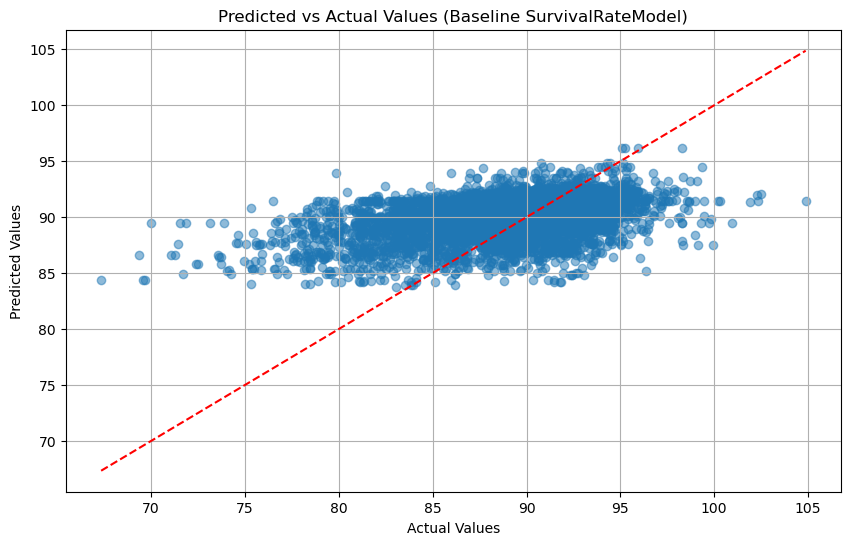

Results for One Layer No Sigmoid:
  R² Score: 0.1631
  Mean Absolute Error: 2.9147
  Root Mean Squared Error: 3.7903


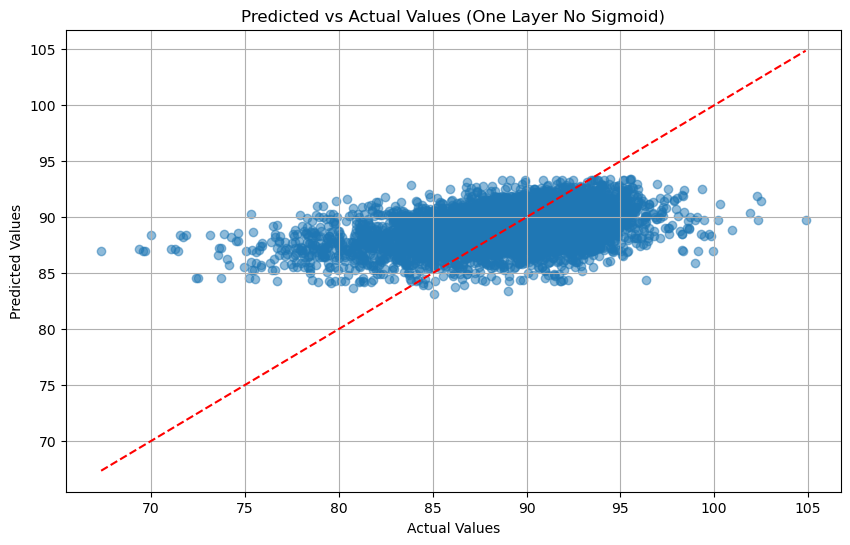

Results for Deep Narrow No Sigmoid:
  R² Score: 0.1458
  Mean Absolute Error: 2.9543
  Root Mean Squared Error: 3.8294


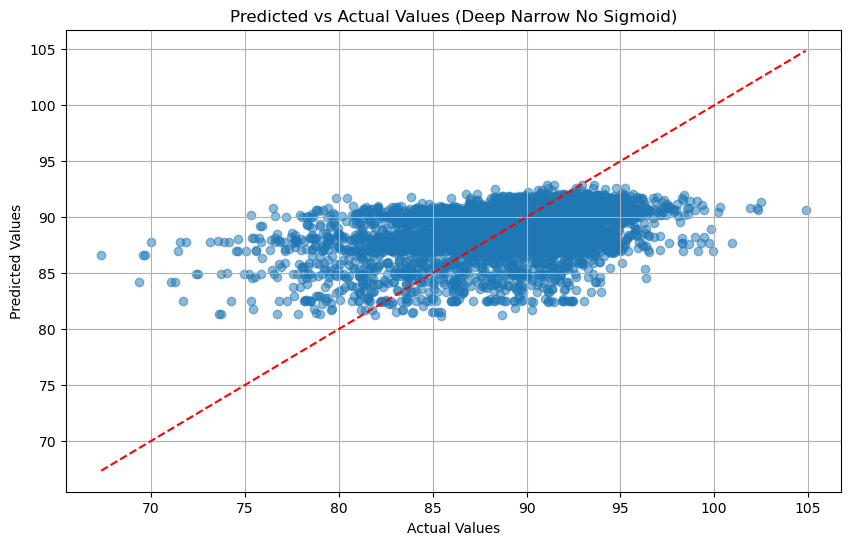

Results for Modified Sigmoid (65-100):
  R² Score: -340701.4079
  Mean Absolute Error: 2418.3936
  Root Mean Squared Error: 2418.3970


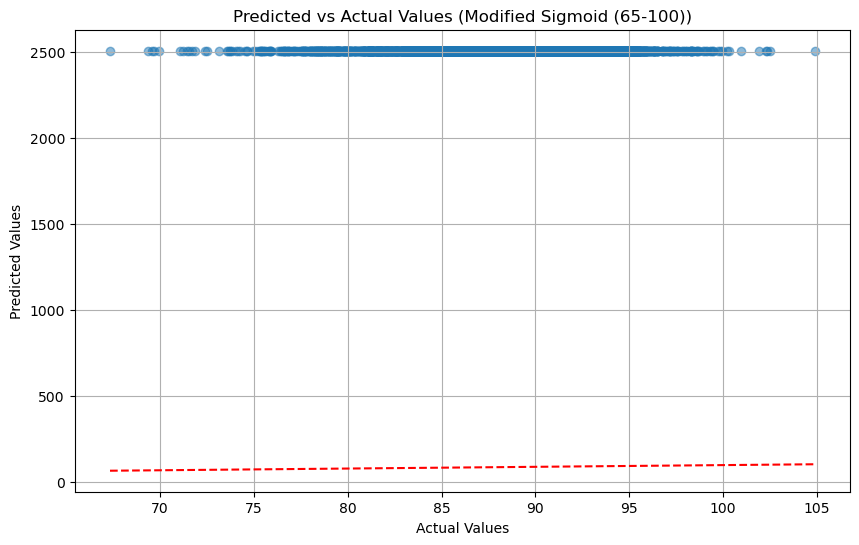

Results for Breadth Loss Model:
  R² Score: 0.1843
  Mean Absolute Error: 2.8578
  Root Mean Squared Error: 3.7419


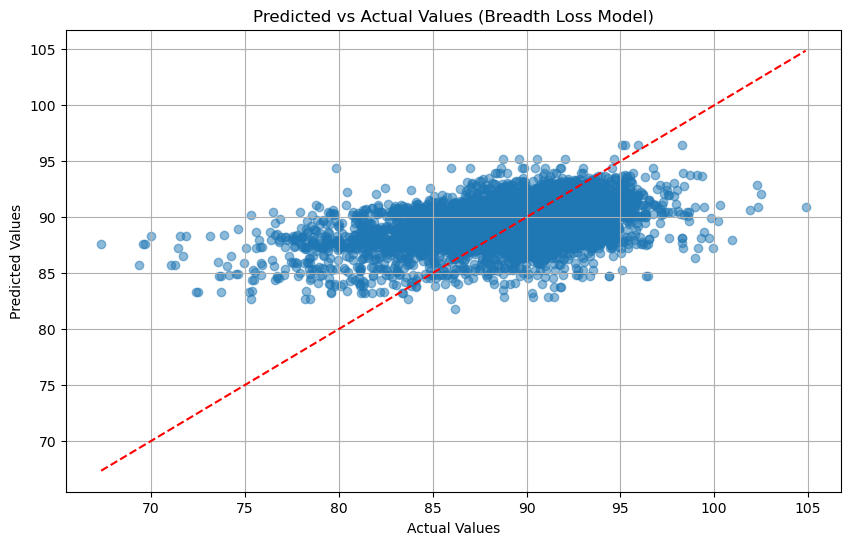

Results for LR Scheduler Model:
  R² Score: 0.1567
  Mean Absolute Error: 2.8721
  Root Mean Squared Error: 3.8049


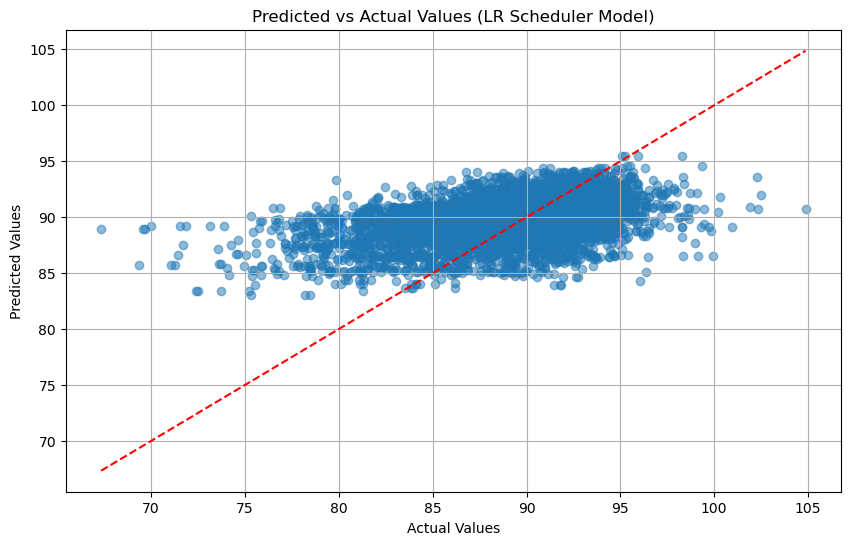

Results for RMSprop Optimizer:
  R² Score: 0.1107
  Mean Absolute Error: 2.9254
  Root Mean Squared Error: 3.9071


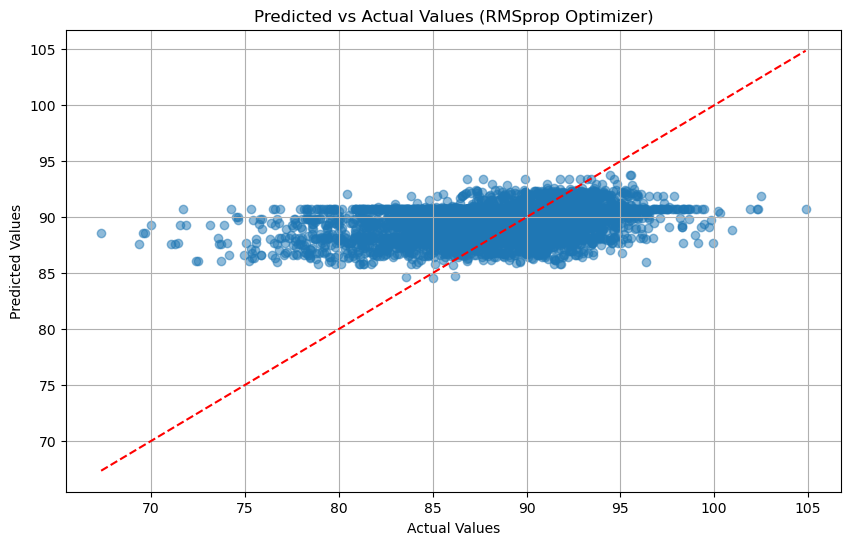

Results for Adagrad Optimizer:
  R² Score: 0.0700
  Mean Absolute Error: 3.0434
  Root Mean Squared Error: 3.9957


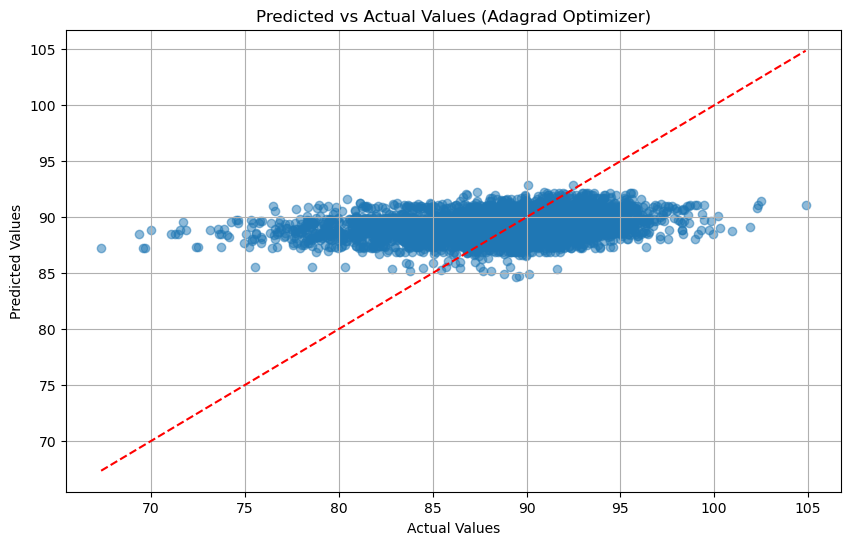

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

models = []
model_names = []
train_dataloaders = []
test_dataloaders = []
val_dataloaders = []

# Create DataLoaders with the new EconDataset
train_dataset = EconDataset(train_data, "State", "Industry", "Unemployment Rate", "Response")
test_dataset = EconDataset(test_data, "State", "Industry", "Unemployment Rate", "Response")
val_dataset = EconDataset(val_data, "State", "Industry", "Unemployment Rate", "Response")
input_size = len(train_dataset[0][0])
bs = 128

train_dataloader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=bs, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=bs, shuffle=False)

train_dataloaders.append(train_dataloader)
test_dataloaders.append(test_dataloader)
val_dataloaders.append(val_dataloader)

# 1. Baseline SurvivalRateModel
model_baseline = SurvivalRateModel(input_size=input_size, hidden_size1=256, hidden_size2=128, dropout=0.1)
models.append(model_baseline)
model_names.append("Baseline SurvivalRateModel")

# 2. One Hidden Layer, No Sigmoid
class OneLayerModel(SurvivalRateModel):
    def __init__(self, input_size, hidden_size):
        super().__init__(input_size, hidden_size, hidden_size, dropout=0)
        self.layers =nn.Sequential(nn.Linear(input_size, hidden_size), nn.ReLU(), nn.Linear(hidden_size, 1))


    def forward(self, x):
        return self.layers(x)

model_one_layer = OneLayerModel(input_size=input_size, hidden_size=128)
models.append(model_one_layer)
model_names.append("One Layer No Sigmoid")

# 3. Many Layers, Small Hidden Sizes, No Sigmoid
class DeepNarrowModel(SurvivalRateModel):
    def __init__(self, input_size, hidden_size=8, num_layers=5):
        super().__init__(input_size, hidden_size, hidden_size, dropout=0)
        layers = [nn.Linear(input_size, hidden_size), nn.ReLU()]
        for _ in range(num_layers - 1):
            layers.extend([nn.Linear(hidden_size, hidden_size), nn.ReLU()])
        layers.append(nn.Linear(hidden_size, 1))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

model_deep_narrow = DeepNarrowModel(input_size=input_size)
models.append(model_deep_narrow)
model_names.append("Deep Narrow No Sigmoid")

# 4. Modified Sigmoid Output (65-100)
class ModifiedSigmoidModel(SurvivalRateModel):
    def forward(self, x):
        return 65 + 35 * torch.sigmoid(self.layers(x))

model_modified_sigmoid = ModifiedSigmoidModel(input_size=input_size, hidden_size1=256, hidden_size2=128, dropout=0.1)
models.append(model_modified_sigmoid)
model_names.append("Modified Sigmoid (65-100)")

# 5. Breadth Loss Model
class BreadthLossModel(SurvivalRateModel):
    def train_step(self, x, y, criterion, optimizer, breadth_lambda=0.01):
        optimizer.zero_grad()
        outputs = self(x)
        loss = criterion(outputs, y)
        breadth_loss = -torch.std(outputs)
        total_loss = loss + breadth_lambda * breadth_loss
        total_loss.backward()
        optimizer.step()
        return total_loss.item()

    def train_loop(self, dataloader, num_epochs=150, learning_rate=0.001, device="cpu", val_dataloader=None, suppress=False, patience=40, uses_wandb=False, optimizer=None, breadth_lambda=0.01):
        return super().train_loop(dataloader, num_epochs=num_epochs, learning_rate=learning_rate, device=device, suppress=suppress, optimizer=optimizer, val_dataloader=val_dataloader, patience=patience, uses_wandb=uses_wandb)

model_breadth_loss = BreadthLossModel(input_size=input_size, hidden_size1=256, hidden_size2=128, dropout=0.1)
models.append(model_breadth_loss)
model_names.append("Breadth Loss Model")

# 6. Learning Rate Scheduler
class LRSchedulerModel(SurvivalRateModel):
    def train_loop(self, dataloader, num_epochs=150, learning_rate=0.001, device="cpu", val_dataloader=None, suppress=False, patience=40, uses_wandb=False, gamma=0.95):
        self.to(device)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
        train_loss_cache, val_loss_cache = super().train_loop(dataloader, num_epochs, learning_rate, device=device, suppress=suppress, val_dataloader=val_dataloader, patience=patience, uses_wandb=uses_wandb)
        for epoch in range(len(train_loss_cache)):
            scheduler.step()
        return train_loss_cache, val_loss_cache

model_lr_scheduler = LRSchedulerModel(input_size=input_size, hidden_size1=256, hidden_size2=128, dropout=0.1)
models.append(model_lr_scheduler)
model_names.append("LR Scheduler Model")

# 7. Optimizer: SGD
class SGDModel(SurvivalRateModel):
    def train_loop(self, dataloader, num_epochs=150, learning_rate=0.01, device="cpu", val_dataloader=None, suppress=False, patience=40, uses_wandb=False):
        optimizer = optim.SGD(self.parameters(), lr=learning_rate)
        return super().train_loop(dataloader, num_epochs, learning_rate, device=device, suppress=suppress, val_dataloader=val_dataloader, patience=patience, uses_wandb=uses_wandb, optimizer=optimizer)

model_sgd = SGDModel(input_size=input_size, hidden_size1=256, hidden_size2=128, dropout=0.1)
models.append(model_sgd)
model_names.append("SGD Optimizer")

# 8. Optimizer: RMSprop
class RMSpropModel(SurvivalRateModel):
    def train_loop(self, dataloader, num_epochs=150, learning_rate=0.001, device="cpu", val_dataloader=None, suppress=False, patience=40, uses_wandb=False):
        optimizer = optim.RMSprop(self.parameters(), lr=learning_rate)
        return super().train_loop(dataloader=dataloader, num_epochs=num_epochs, learning_rate=learning_rate, device=device, suppress=suppress, val_dataloader=val_dataloader, patience=patience, uses_wandb=uses_wandb, optimizer=optimizer)

model_rmsprop = RMSpropModel(input_size=input_size, hidden_size1=256, hidden_size2=128, dropout=0.1)
models.append(model_rmsprop)
model_names.append("RMSprop Optimizer")

# 9. Optimizer: Adagrad
class AdagradModel(SurvivalRateModel):
    def train_loop(self, dataloader, num_epochs=150, learning_rate=0.01, device="cpu", val_dataloader=None, suppress=False, patience=40, uses_wandb=False):
        optimizer = optim.Adagrad(self.parameters(), lr=learning_rate)
        return super().train_loop(dataloader=dataloader, num_epochs=num_epochs, learning_rate=learning_rate, device=device, suppress=suppress, val_dataloader=val_dataloader, patience=patience, uses_wandb=uses_wandb, optimizer=optimizer)

model_adagrad = AdagradModel(input_size=input_size, hidden_size1=256, hidden_size2=128, dropout=0.1)
models.append(model_adagrad)
model_names.append("Adagrad Optimizer")

# Training and Evaluation Loop (same as before)
num_epochs = 150
device = "cpu"

# results = []

for i, model in enumerate(models):
    if i < 7:
        continue
    print(f"Training {model_names[i]}...")
    if isinstance(model, BreadthLossModel):
        train_loss_cache, val_loss_cache = model.train_loop(
            train_dataloaders[0],
            num_epochs=num_epochs,
            learning_rate=0.001,
            device=device,
            val_dataloader=val_dataloaders[0],
            suppress=True,
            patience=50,
            breadth_lambda=0.01  # Pass breadth_lambda for BreadthLossModel
        )
    elif isinstance(model, LRSchedulerModel):
        train_loss_cache, val_loss_cache = model.train_loop(
            train_dataloaders[0],
            num_epochs=num_epochs,
            learning_rate=0.001,
            device=device,
            val_dataloader=val_dataloaders[0],
            suppress=True,
            patience=50,
            gamma=0.95  # Pass gamma for LRSchedulerModel
        )
    else:
        train_loss_cache, val_loss_cache = model.train_loop(
            train_dataloaders[0],
            num_epochs=num_epochs,
            learning_rate=0.001,
            device=device,
            val_dataloader=val_dataloaders[0],
            suppress=False,
            patience=50,
        )

    y_pred, y_true = model.evaluate(test_dataloaders[0], device=device)

    # Denormalize predictions and actual values
    y_pred_denorm = train_dataset.denormalize_response(y_pred)
    y_true_denorm = train_dataset.denormalize_response(y_true)

    r2 = r2_score(y_true_denorm, y_pred_denorm)
    mae = mean_absolute_error(y_true_denorm, y_pred_denorm)
    rmse = np.sqrt(mean_squared_error(y_true_denorm, y_pred_denorm))

    results.append({
        "model_name": model_names[i],
        "r2": r2,
        "mae": mae,
        "rmse": rmse,
        "y_pred": y_pred_denorm,
        "y_true": y_true_denorm,
    })


Results for Baseline SurvivalRateModel:
  R² Score: 0.1502
  Mean Absolute Error: 2.8579
  Root Mean Squared Error: 3.8194


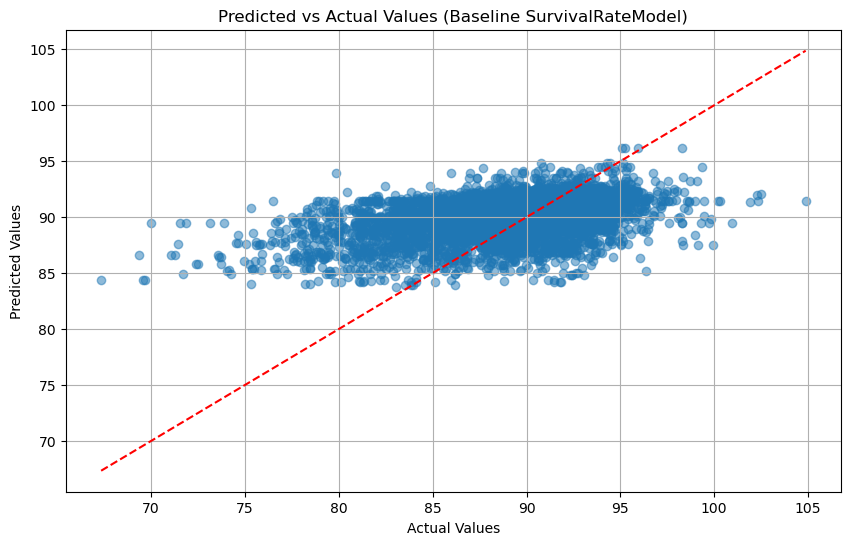

Results for One Layer No Sigmoid:
  R² Score: 0.1631
  Mean Absolute Error: 2.9147
  Root Mean Squared Error: 3.7903


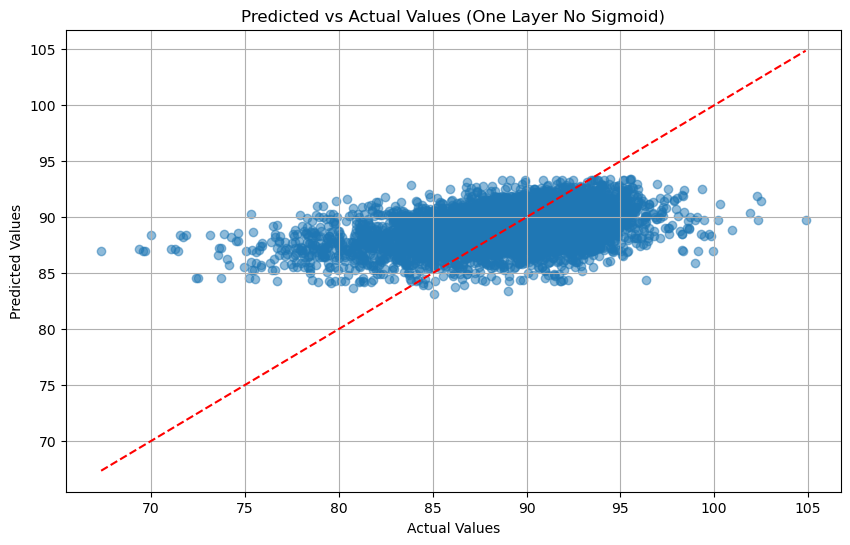

Results for Deep Narrow No Sigmoid:
  R² Score: 0.1458
  Mean Absolute Error: 2.9543
  Root Mean Squared Error: 3.8294


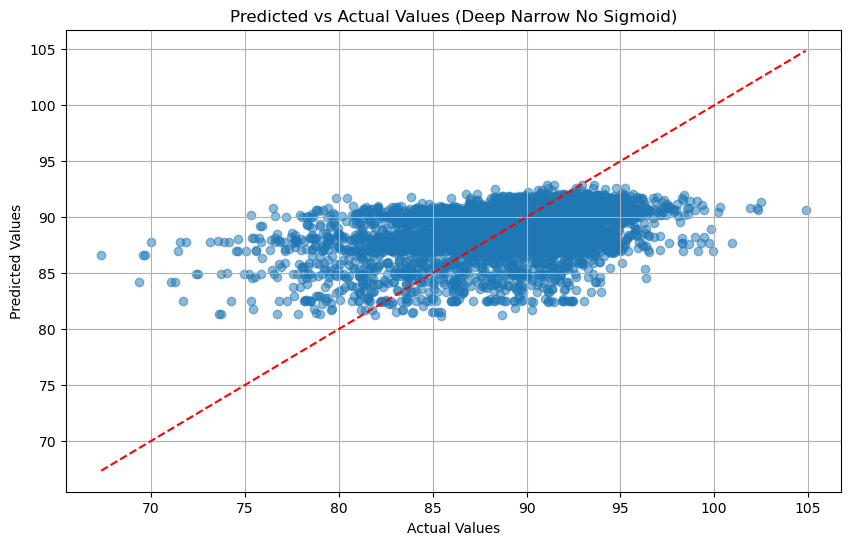

Results for Modified Sigmoid (65-100):
  R² Score: -340701.4079
  Mean Absolute Error: 2418.3936
  Root Mean Squared Error: 2418.3970


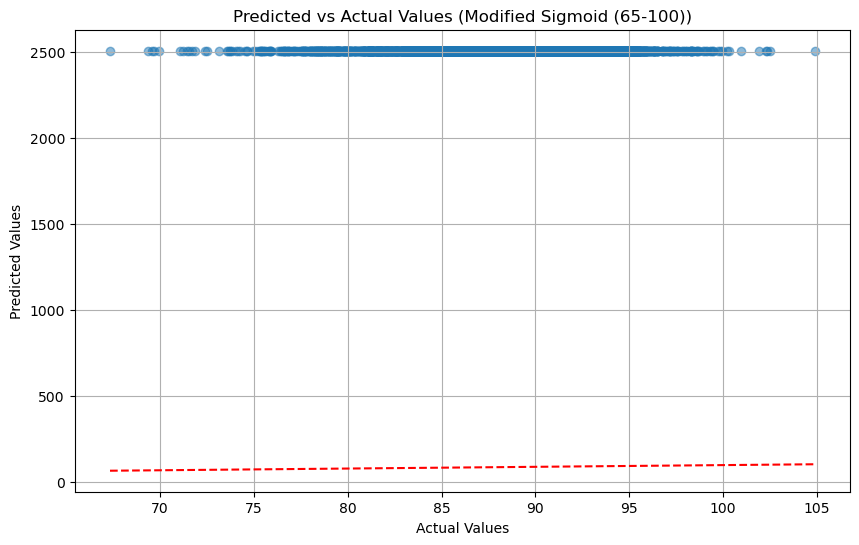

Results for Breadth Loss Model:
  R² Score: 0.1843
  Mean Absolute Error: 2.8578
  Root Mean Squared Error: 3.7419


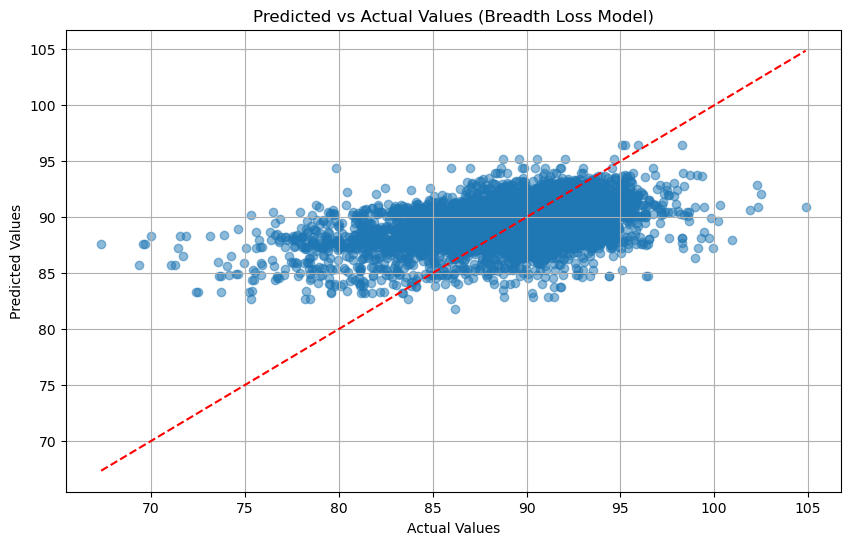

Results for LR Scheduler Model:
  R² Score: 0.1567
  Mean Absolute Error: 2.8721
  Root Mean Squared Error: 3.8049


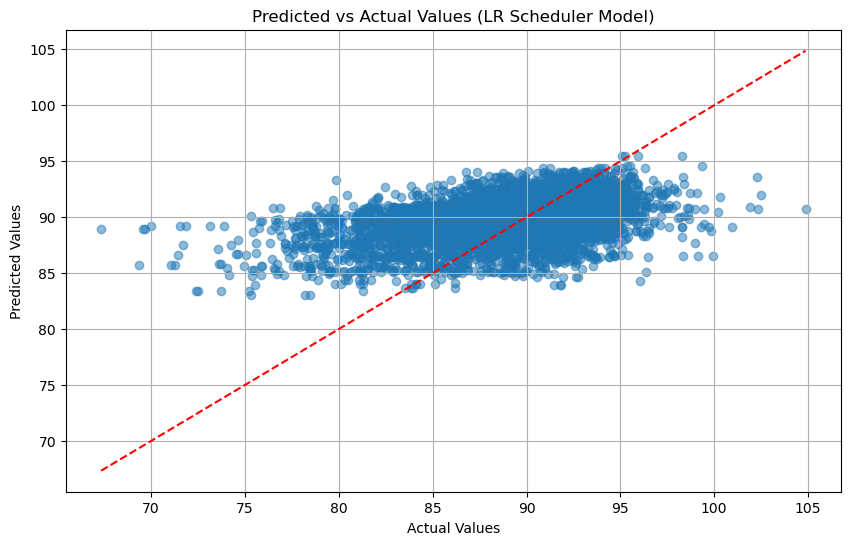

Results for RMSprop Optimizer:
  R² Score: 0.1107
  Mean Absolute Error: 2.9254
  Root Mean Squared Error: 3.9071


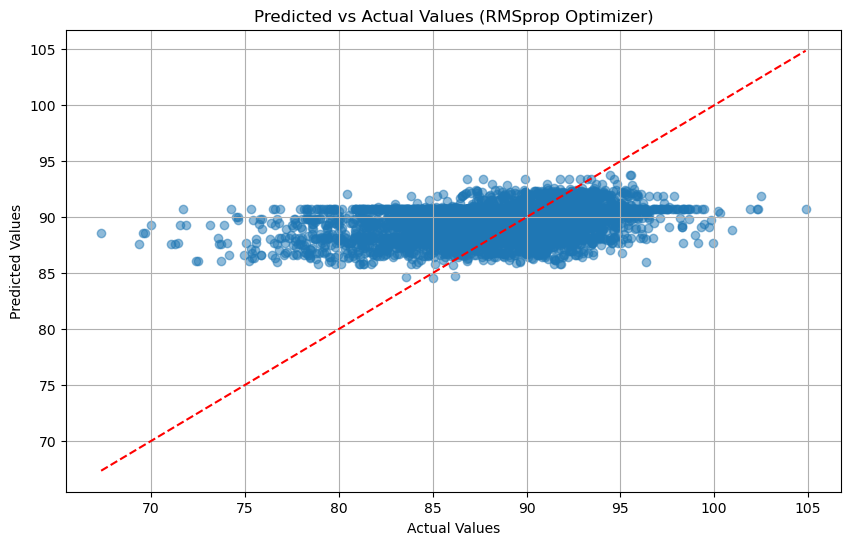

Results for Adagrad Optimizer:
  R² Score: 0.0700
  Mean Absolute Error: 3.0434
  Root Mean Squared Error: 3.9957


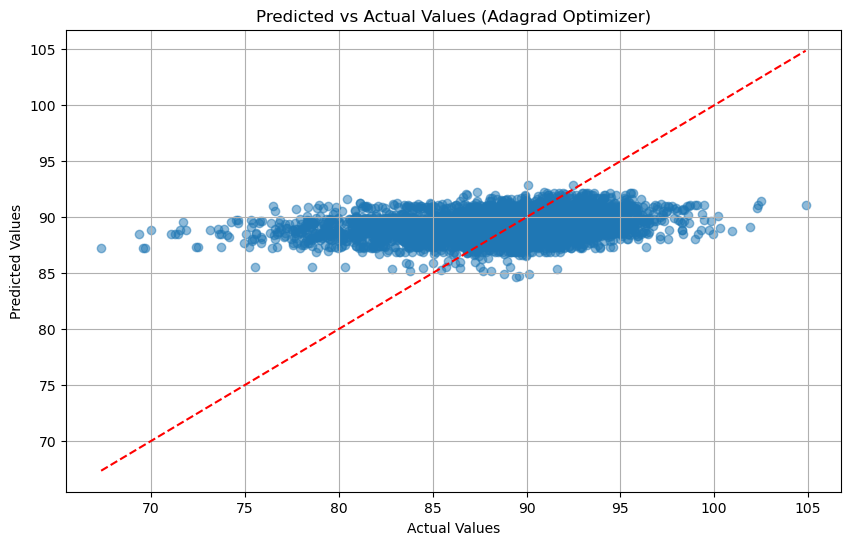

In [20]:
for result in results:
    print(f"Results for {result['model_name']}:")
    print(f"  R² Score: {result['r2']:.4f}")
    print(f"  Mean Absolute Error: {result['mae']:.4f}")
    print(f"  Root Mean Squared Error: {result['rmse']:.4f}")

    plt.figure(figsize=(10, 6))
    plt.scatter(result['y_true'], result['y_pred'], alpha=0.5)
    plt.plot([min(result['y_true']), max(result['y_true'])], [min(result['y_true']), max(result['y_true'])], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f"Predicted vs Actual Values ({result['model_name']})")
    plt.grid(True)
    plt.show()

#### v4:

In [20]:
models = []
model_names = []
train_dataloaders = []
test_dataloaders = []
val_dataloaders = []

# Create DataLoaders with the new EconDataset
train_dataset = EconDataset(train_data, "State", "Industry", "Unemployment Rate", "Response")
test_dataset = EconDataset(test_data, "State", "Industry", "Unemployment Rate", "Response")
val_dataset = EconDataset(val_data, "State", "Industry", "Unemployment Rate", "Response")
input_size = len(train_dataset[0][0])
bs = 128

train_dataloader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=bs, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=bs, shuffle=False)

train_dataloaders.append(train_dataloader)
test_dataloaders.append(test_dataloader)
val_dataloaders.append(val_dataloader)


# 1. Baseline SurvivalRateModel
model_baseline = SurvivalRateModel(input_size=input_size, hidden_size1=256, hidden_size2=128, dropout=0.1)
models.append(model_baseline)
model_names.append("Baseline SurvivalRateModel")

# 2. Embedded SurvivalRateModel
model_baseline = SurvivalRateModel_Embeddings(num_states=51, num_industries=19, hidden_size1=256, hidden_size2=128)
models.append(model_baseline)
model_names.append("Baseline SurvivalRateModel")

# 3-5. Breadth Loss Model
class BreadthLossModel(SurvivalRateModel):
    def train_step(self, x, y, criterion, optimizer, breadth_lambda=0.01):
        optimizer.zero_grad()
        outputs = self(x)
        loss = criterion(outputs, y)
        breadth_loss = -torch.std(outputs)
        total_loss = loss + breadth_lambda * breadth_loss
        total_loss.backward()
        optimizer.step()
        return total_loss.item()

    def train_loop(self, dataloader, num_epochs=150, learning_rate=0.001, device="cpu", val_dataloader=None, suppress=False, patience=40, uses_wandb=False, optimizer=None, breadth_lambda=0.01):
        return super().train_loop(dataloader, num_epochs, learning_rate, device=device, suppress=suppress, optimizer=optimizer, val_dataloader=val_dataloader, patience=patience, uses_wandb=uses_wandb)

model_breadth_loss_low = BreadthLossModel(input_size=input_size, hidden_size1=256, hidden_size2=128)
models.append(model_breadth_loss_low)
model_names.append("Breadth Loss Low Model")

model_breadth_loss_med = BreadthLossModel(input_size=input_size, hidden_size1=256, hidden_size2=128)
models.append(model_breadth_loss_med)
model_names.append("Breadth Loss Med Model")

model_breadth_loss_high = BreadthLossModel(input_size=input_size, hidden_size1=256, hidden_size2=128)
models.append(model_breadth_loss_high)
model_names.append("Breadth Loss High Model")

# 6. Breadth Loss Embeddings
class BreadthLossModelEmbed(SurvivalRateModel_Embeddings):
    def train_step(self, x, y, criterion, optimizer, breadth_lambda=0.01):
        optimizer.zero_grad()
        outputs = self(x)
        loss = criterion(outputs, y)
        breadth_loss = -torch.std(outputs)
        total_loss = loss + breadth_lambda * breadth_loss
        total_loss.backward()
        optimizer.step()
        return total_loss.item()

    def train_loop(self, dataloader, num_epochs=150, learning_rate=0.001, device="cpu", val_dataloader=None, suppress=False, patience=40, uses_wandb=False, optimizer=None, breadth_lambda=0.01):
        return super().train_loop(dataloader, num_epochs, learning_rate, device=device, suppress=suppress, optimizer=optimizer, val_dataloader=val_dataloader, patience=patience, uses_wandb=uses_wandb)

model_breadth_embed = BreadthLossModelEmbed(num_states=51, num_industries=19, hidden_size1=256, hidden_size2=128)
models.append(model_breadth_embed)
model_names.append("Model Breadth Embed Model")
num_epochs = 150
device='cpu'
results = []

for i, model in enumerate(models):
    print(f"Training {model_names[i]}...")
    if isinstance(model, BreadthLossModel):
        train_loss_cache, val_loss_cache = model.train_loop(
            train_dataloaders[0],
            num_epochs=num_epochs,
            learning_rate=0.001,
            device=device,
            val_dataloader=val_dataloaders[0],
            suppress=True,
            patience=50,
            breadth_lambda=0.01 * 10**float(i-2)  # Pass breadth_lambda for BreadthLossModel
        )
    elif isinstance(model, BreadthLossModelEmbed):
        train_loss_cache, val_loss_cache = model.train_loop(
            train_dataloaders[0],
            num_epochs=num_epochs,
            learning_rate=0.001,
            device=device,
            val_dataloader=val_dataloaders[0],
            suppress=True,
            patience=50,
        )
    else:
        train_loss_cache, val_loss_cache = model.train_loop(
            train_dataloaders[0],
            num_epochs=num_epochs,
            learning_rate=0.001,
            device=device,
            val_dataloader=val_dataloaders[0],
            suppress=True,
            patience=50,
        )

    y_pred, y_true = model.evaluate(test_dataloaders[0], device=device)

    # Denormalize predictions and actual values
    y_pred_denorm = train_dataset.denormalize_response(y_pred)
    y_true_denorm = train_dataset.denormalize_response(y_true)

    r2 = r2_score(y_true_denorm, y_pred_denorm)
    mae = mean_absolute_error(y_true_denorm, y_pred_denorm)
    rmse = np.sqrt(mean_squared_error(y_true_denorm, y_pred_denorm))

    results.append({
        "model_name": model_names[i],
        "r2": r2,
        "mae": mae,
        "rmse": rmse,
        "y_pred": y_pred_denorm,
        "y_true": y_true_denorm,
    })


Training Baseline SurvivalRateModel...


Training Epochs: 100%|██████████| 150/150 [01:41<00:00,  1.47it/s]


Training Baseline SurvivalRateModel...


Training Epochs: 100%|██████████| 150/150 [01:36<00:00,  1.56it/s]


Training Breadth Loss Low Model...


Training Epochs: 100%|██████████| 150/150 [01:37<00:00,  1.55it/s]


Training Breadth Loss Med Model...


Training Epochs: 100%|██████████| 150/150 [01:38<00:00,  1.52it/s]


Training Breadth Loss High Model...


Training Epochs: 100%|██████████| 150/150 [01:34<00:00,  1.58it/s]


Training Model Breadth Embed Model...


Training Epochs: 100%|██████████| 150/150 [01:36<00:00,  1.55it/s]


Results for Baseline SurvivalRateModel:
  R² Score: 0.1268
  Mean Absolute Error: 2.9097
  Root Mean Squared Error: 3.8717


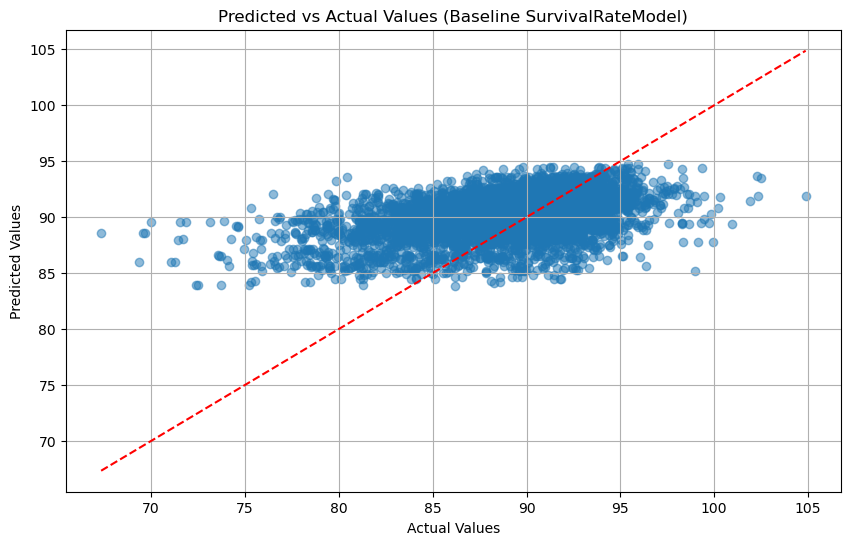

Results for Baseline SurvivalRateModel:
  R² Score: 0.1241
  Mean Absolute Error: 2.9528
  Root Mean Squared Error: 3.8777


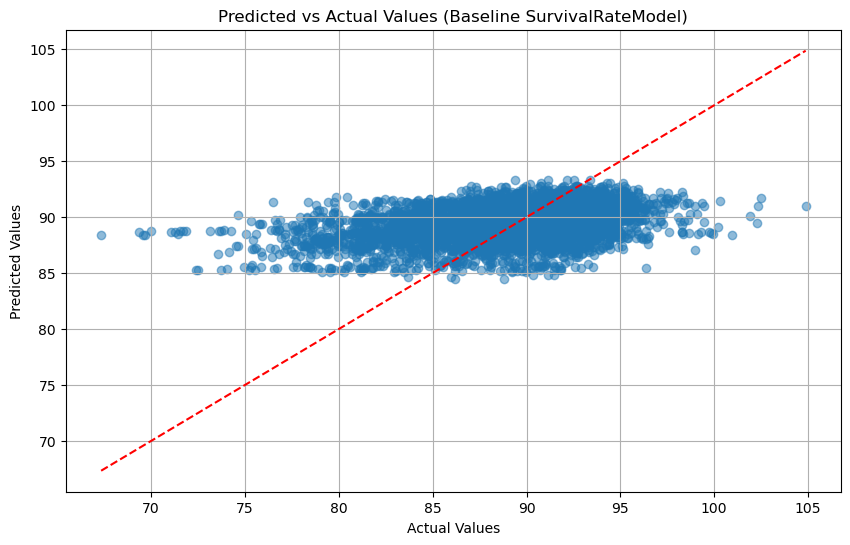

Results for Breadth Loss Low Model:
  R² Score: 0.1347
  Mean Absolute Error: 2.9356
  Root Mean Squared Error: 3.8541


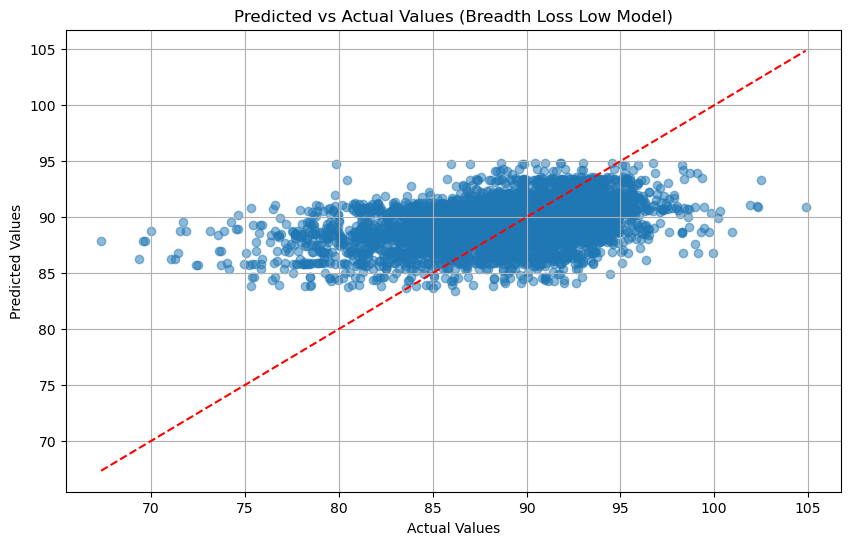

Results for Breadth Loss Med Model:
  R² Score: 0.1591
  Mean Absolute Error: 2.9142
  Root Mean Squared Error: 3.7993


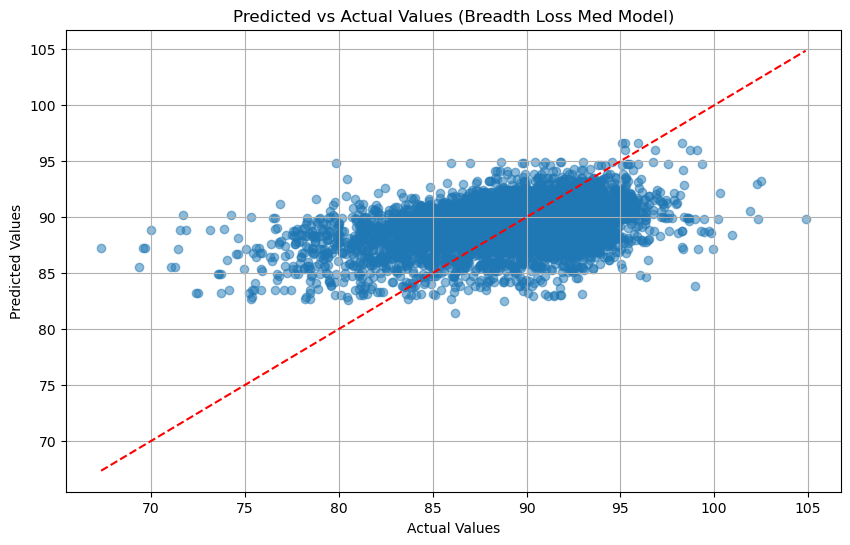

Results for Breadth Loss High Model:
  R² Score: 0.1404
  Mean Absolute Error: 2.8879
  Root Mean Squared Error: 3.8414


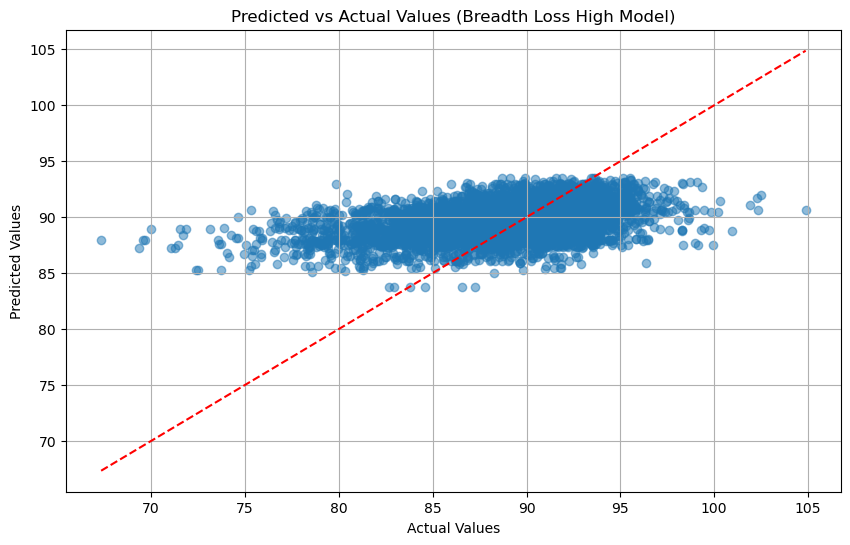

Results for Model Breadth Embed Model:
  R² Score: 0.1241
  Mean Absolute Error: 3.0448
  Root Mean Squared Error: 3.8777


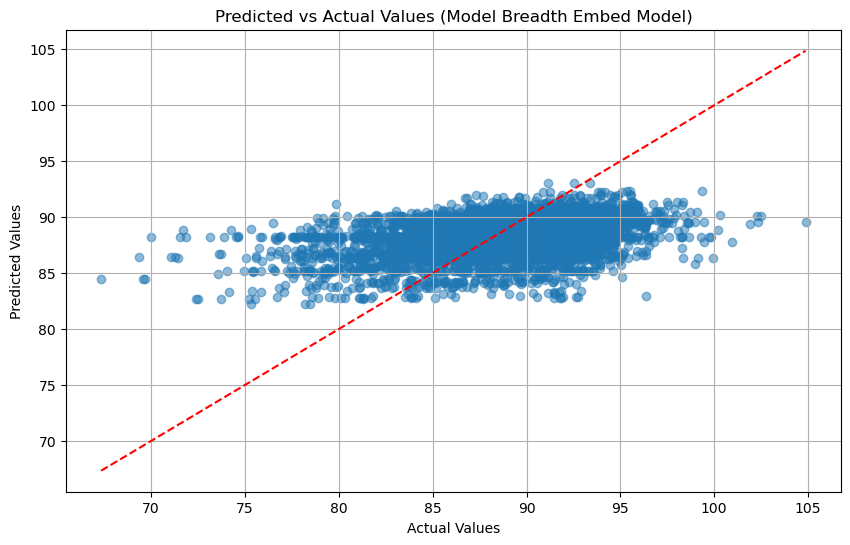

In [21]:
for result in results:
    print(f"Results for {result['model_name']}:")
    print(f"  R² Score: {result['r2']:.4f}")
    print(f"  Mean Absolute Error: {result['mae']:.4f}")
    print(f"  Root Mean Squared Error: {result['rmse']:.4f}")

    plt.figure(figsize=(10, 6))
    plt.scatter(result['y_true'], result['y_pred'], alpha=0.5)
    plt.plot([min(result['y_true']), max(result['y_true'])], [min(result['y_true']), max(result['y_true'])], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f"Predicted vs Actual Values ({result['model_name']})")
    plt.grid(True)
    plt.show()

### Hyperparameter Tuning

Initialize a couple rounds of tuning

In [ ]:
def train_with_wandb(config=None):

    with wandb.init(config=config, project="survival-rate-random-search", entity="sebastian-seljak-ucla") as run:
        config = wandb.config

        model = SurvivalRateModel_Combined(
            input_size=input_size,
            hidden_size1=config.hidden_size1,
            hidden_size2=config.hidden_size2,
            hidden_size3 = config.hidden_size3, 
            hidden_size4 = config.hidden_size4, 
            output_size = 1, 
            l1_lambda = config.l1_lambda, 
            l2_lambda = config.l2_lambda, 
            noise_std=config.noise_std, 
            dropout_rate=config.dropout_rate
        )

        train_dataloader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
        test_dataloader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)
        val_dataloader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)

        train_loss_cache, val_loss_cache = model.train_loop(
            train_dataloader,
            num_epochs=50,
            learning_rate=config.learning_rate,
            device="cpu",
            suppress=True,
            val_dataloader=val_dataloader,
            patience=5,
        )
        best_val_loss = min(val_loss_cache)

        predicted, actual = model.evaluate(test_dataloader, device="cpu")
        test_loss = np.mean(abs(predicted - actual))
        wandb.log({"test_loss": test_loss, "best_val_loss": best_val_loss})

# Define the sweep configuration
sweep_config = {
    "method": "random",
    "metric": {"name": "best_val_loss", "goal": "minimize"},
    "parameters": {
        "hidden_size1": {"values": [32, 64, 128, 256, 512]},
        "hidden_size2": {"values": [32, 64, 128, 256]},
        "hidden_size3": {"values": [32, 64, 128, 256]},
        "hidden_size4": {"values": [16, 32, 64, 128]},
        "learning_rate": {"min": 1e-6, "max": 1e-1, "distribution": "log_uniform_values"},
        "l1_lambda": {"min": 1e-5, "max": 1e-2, "distribution": "log_uniform_values"},
        "l2_lambda": {"min": 1e-4, "max": 1e-1, "distribution": "log_uniform_values"},
        "noise_std": {"min": 0.01, "max": 0.1, "distribution": "uniform"},
        "dropout_rate": {"min": 0.0, "max": 0.5, "distribution": "uniform"},
        "batch_size": {"values": [32, 64, 128, 256, 512]},
    },
}

# Create the sweep (moved outside the function)
sweep_id = wandb.sweep(sweep_config, project="survival-rate-random-search", entity="sebastian-seljak-ucla")

# Run the sweep agent
wandb.agent(sweep_id, train_with_wandb, count=300)

Round 2

In [ ]:
def train_with_wandb(config=None):

    with wandb.init(config=config, project="survival-rate-random-search-round2", entity="sebastian-seljak-ucla") as run:
        config = wandb.config

        model = SurvivalRateModel_Combined(
            input_size=input_size,
            hidden_size1=config.hidden_size1,
            hidden_size2=config.hidden_size2,
            hidden_size3 = config.hidden_size3, 
            hidden_size4 = config.hidden_size4, 
            output_size = 1, 
            l1_lambda = config.l1_lambda, 
            l2_lambda = config.l2_lambda, 
            noise_std=config.noise_std, 
            dropout_rate=config.dropout_rate
        )

        train_dataloader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
        test_dataloader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)
        val_dataloader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)

        train_loss_cache, val_loss_cache = model.train_loop(
            train_dataloader,
            num_epochs=50,
            learning_rate=config.learning_rate,
            device="cpu",
            suppress=True,
            val_dataloader=val_dataloader,
            patience=5,
        )
        best_val_loss = min(val_loss_cache)

        predicted, actual = model.evaluate(test_dataloader, device="cpu")
        test_loss = np.mean(abs(predicted - actual))
        wandb.log({"test_loss": test_loss, "best_val_loss": best_val_loss})

# Define the sweep configuration
sweep_config = {
    "method": "random",
    "metric": {"name": "best_val_loss", "goal": "minimize"},
    "parameters": {
        "hidden_size1": {"values": [32, 64, 128, 256, 512]},
        "hidden_size2": {"values": [32, 64, 128, 256]},
        "hidden_size3": {"values": [32, 64, 128, 256]},
        "hidden_size4": {"values": [64, 128, 256]},
        "learning_rate": {"min": 1e-4, "max": 5e-1, "distribution": "log_uniform_values"},
        "l1_lambda": {"min": 1e-5, "max": 1e-2, "distribution": "log_uniform_values"},
        "l2_lambda": {"min": 1e-4, "max": 1e-1, "distribution": "log_uniform_values"},
        "noise_std": {"min": 0.05, "max": 0.2, "distribution": "uniform"},
        "dropout_rate": {"min": 0.0, "max": 0.25, "distribution": "uniform"},
        "batch_size": {"values": [16,32, 64, 128]},
    },
}

# Create the sweep (moved outside the function)
sweep_id = wandb.sweep(sweep_config, project="survival-rate-random-search-round2", entity="sebastian-seljak-ucla")

# Run the sweep agent
wandb.agent(sweep_id, train_with_wandb, count=30)

### Tweaking Best Model

In [ ]:
best_params = (512, 64, 64, 64, 1e-2, 1e-1, 1e-3, 128, 0.05, 0.25, 300)
h1, h2, h3, h4, l1, l2, lr, bs, noise, drop, ep = best_params
l1 = l1
l2 = l2
lr = lr


input_size = len(train_dataset[0][0])


train_dataloader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=bs, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=bs, shuffle=False)

model_regged = SurvivalRateModel_Combined(input_size=input_size,
            hidden_size1=h1,
            hidden_size2=h2,
            hidden_size3 = h3,
            hidden_size4 = h4,
            output_size = 1, 
            l1_lambda = l1, 
            l2_lambda = l2,
            noise_std=noise, 
            dropout_rate=drop)
loss_data_regged = model_regged.train_loop(train_dataloader, num_epochs=ep, learning_rate=lr, device="cpu", val_dataloader=val_dataloader, suppress=True, patience=2000)


In [ ]:
import pickle

# Save the model to a file
with open('models/model_combined_final.pkl', 'wb') as f:
    pickle.dump([model_regged, loss_data_regged], f)